# Final Project

Kraus Fabian - Juzova Silvia - Caruso Alessandro - Gazzaneo Rocco - Rezai Arian

### Table of Contents

* [Research Topic](#researchquestion)
* [Chapter 1: Data, Preprocessing and Analysis](#chapter1)
    * [Section 1.1: Before Preprocessing Statistics](#section_1_1)
    * [Section 1.2: Preprocessing](#section_1_2)
    * [Section 1.3: After Preprocessing Statistics](#section_1_3)
    * [Section 1.4: Analysis](#section_1_4)
        * [Topic Models Yelp Dataset: LDA and Author](#subsection_1_4_1)
        * [Word Embeddings](#subsection_1_4_2)
        * [Doc2Vec: By Stars and k-means clustering of most similar to each star (5 Cluster)](#subsection_1_4_3)
* [Chapter 2: Language Models](#chapter2)
    * [Structured Perceptron](#subsection_2_1_1)
    * [Character Based RNN](#subsection_2_1_2)
    * [Word Based LSTM](#subsection_2_1_3)
* [Chapter 3: Prediction](#chapter3)
    * [Data Preprocessing](#subsection_3_1_1)
        * Summary
    * [Baseline Classifiers](#subsection_3_1_2)
        * Dummy Classifier
        * The HULK
    * [Naive Bayes](#subsection_2_1_5)
    * [Random Forest Classifier](#subsection_3_1_3)
    * [SVC Classifier] 
    * [CNN](#subsection_3_1_4)
        * CNN with Attention
        * CNN
    * [Transformer](#subsection_3_1_5)

* [Chapter 4: Performance Comparison](#chapter4)
    * [Classification on Real Reviews: HULK and Best Classifier](#subsection_4_1)
    * [Comparison](#subsection_4_2)
        *  Bootstrap Comparison
        *  General Performance Comparison
        
* [Chapter 5: Conclusion](#chapter5)
 
    

    
        
    
    

In [3]:
"""
Import of necessary packages for the analysis
"""

%config InlineBackend.figure_format = 'svg'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy
from collections import Counter
import re
from nltk import ngrams
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from string import digits
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases
import time
import multiprocessing 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from langdetect import detect #you may need to install this
from sklearn.model_selection import train_test_split


nlp = spacy.load('en_core_web_sm')
sns.set_style("white")
plt.rcParams.update({'font.size': 12, 'font.style': 'normal', 'font.family':'palatino'})
palette = sns.color_palette("magma",30)

# Research Topic<a class="anchor" id="researchquestion"></a>

### **Can generated text through a language model accurately predict the sentiment of a real restaurant review ? - A case study on high-end restaurants in the United States**


The purpose of this study is to gain a deeper understanding in the quality of language models, in particular we want to answer whether a language model can accurately capture varying moods of people around a certain topic. The study further develops a unique method for the verification of a language model by means of training a classification algorithm on a set of fake reviews and using it to predict the sentiment of a real review. 

In order to do so, several language models based on differing methods will be developed. Subsequently a generated sample of 4000 fake reviews for each of these language models will be manually labelled into the sentiment the review captures. This labeling step will at the same time provide a general understanding of the quality of the language model at hand. 

The language model with the most promising results will then be selected to run a sequence of sophisticated classification models trained on these fake reviews. A test set will be used based on a sample of 12000 real reviews. Finally the results of this classification analysis will be compared to a classifcation based on a training set of 4000 real reviews. This will provide the main basis for verification of the success of our language model to capture sentiment. 

## Chapter 1: Data, Preprocessing and Analysis  <a class="anchor" id="chapter1"></a>





### The Dataset

The yelp review datset https://www.yelp.com/dataset was utilised for the research question at hand which consists of a sample of 8,6 million reviews in 8 metropolitan areas. After filtering our for all non-restaurant and low-mid price range restaurants, a subsample of 350k remain. High-end restaurants were decided upon as the center point of analysis due to arguably a difference in the type of customers across the different price ranges, which may use a different type of vocabular and style of writing. This sample is unsurprisingly biased towards the positive reviews. An early finding of this research was the issue of the language models to oversample these positive reviews, and hence it was decided to undersample the positive reviews to arrive at an even split of positive and negative reviews in the dataset. This allowed for a more accurate generation of the negative sentiment in the language model. Upon doing so, a remainder of 200k reviews are left. These are then split as follows: 180k for training the language models, 12k for testing in classification, 4k for training in classification. 

Only this subset of 200k reviews can be found, both with the uncleaned, as well as cleaned text columns in the sql, in the Data folder. The following section will describe the various cleaning done on the data. 

In [4]:
"""
Import and read the data, using a custom function purposely written 
"""

from database import Database

df = Database("Data/NLP_project.db")

"""
The first three sets are there for replicability of the exact parameters 
"""
data = df.query("SELECT * FROM Language_Model_Data")
df_later_train = df.query("SELECT * FROM Train_Classify")
df_later_test = df.query("SELECT * FROM Test_Classify")


"""
This is the complete dataset on which the cleaning is done, it is later split into the 3 datasets above via train_test_split
"""
complete_data = df.query("SELECT * from Complete_High_End")

In [5]:
df.get_tables()

[('Language_Model_Data',), ('Train_Classify',), ('Test_Classify',), ('Fake_LSTM',), ('Fake_RNN',), ('Complete_High_End',)]


In [6]:
import matplotlib.image as mpimg

def image_reader(filename):
    plt.clf()
    fig, ax = plt.subplots(figsize = (14,6))
    img = mpimg.imread(filename)
    imgplot = ax.imshow(img)
    plt.axis("off")
    plt.show()

### Section 1.1: Before preprocessing: statistics <a class="anchor" id="section_1_1"></a>

In [7]:
"""
Compute length and tokenize uncleaned text just for descriptive purposes
"""
def compute_length(x):  
    return len(x.split())

def tokenization(sentence):
    tokens = [token.text.lower() for token in nlp(sentence)]
    return tokens

#entire_dataset['tokens_uncleaned'] = entire_dataset['text'].apply(tokenization)
complete_data['length_uncleaned'] = complete_data['text'].apply(compute_length)

In [8]:
"""
General preprocessing functions
"""

def ngrams_d(data, n): #create n-grams
    return [[gram for gram in ngrams(i, n)] for i in data] 

def flat_list(l):
    return [item for sublist in l for item in sublist]


def mean_bar_plot(data,column,agg_column = "stars",agg_method = "mean",palette = palette):
    plt.clf()
    grouped = data.groupby(column,as_index = False).agg({agg_column:agg_method}).sort_values(by=agg_column,ascending = False)
    fig, ax = plt.subplots(figsize = (10,4))
    if len(grouped) >30:
        grouped = grouped.iloc[:30]
        ax.set_xticks([])
    else: palette = palette[::2]
    
    sns.barplot(x = column,y = agg_column,data = grouped, palette = palette[4::2],saturation=0.8)
    ax.set_title(f"Barplot of {agg_method} {agg_column} by {column}")
    
    return grouped


In [9]:
"""
Descriptive Statistics Plotting Function
"""

def preprocess_plots(data,column,detailed_header = True):
    plt.clf()
    fig,axs = plt.subplots(1,2,figsize = (13,6))
    
    if detailed_header:
        fig.suptitle(f"Document length: {len(data)} reviews over {len(data['name'].unique())} different restaurants across {len(data['state'].unique())} states")
    else: 
        fig.suptitle(f"Document length: {len(data)} reviews")

    ax = axs[0]
    
    #the article length distribution reveals a very small number of outliers - closer analysis not show reveals these include podcast transcripts which will be dropped
    sns.histplot(data = data[column].str.split().str.len(),color = palette[3],binwidth = 5,ax = ax)
    ax.set_xlabel("Length of review")
    ax.set_title("Review Length distribution")
    
    
    ax = axs[1]
    counts = Counter([token for document in data[column] for token in document.split()])
    common_words = [word for word,count in counts.most_common(20)]
    sns.barplot(x = np.arange(20),y = sorted(list(counts.values()),reverse = True)[:20],ci = None,ax = ax,palette=palette)
    ax.set_xticklabels(common_words,rotation=70, horizontalalignment= 'right')
    ax.set_xlabel("Words")
    ax.set_title(f"Distribution of the {len(counts)} Words in the dataset")

    fig.tight_layout(rect = [0,0.03,1,0.95])
    
    return counts

<Figure size 432x288 with 0 Axes>

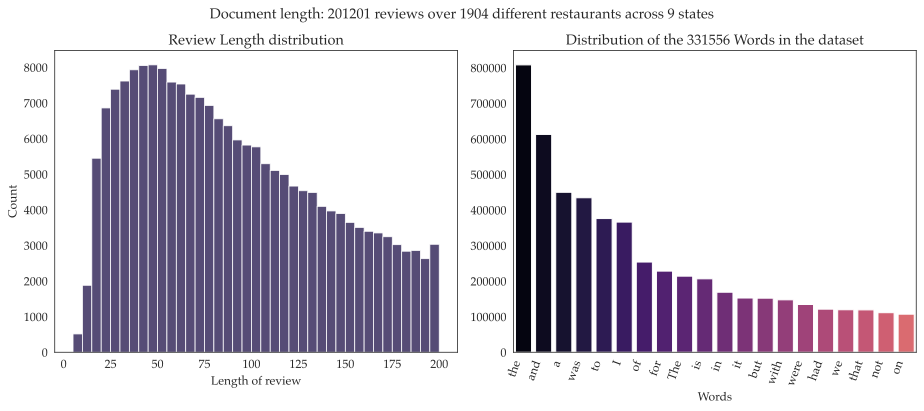

In [10]:
"""
Here we show the total number of documents before preprocessing and some general characteristics
"""
c = preprocess_plots(complete_data,"text")




We can see the review length has been cut beforehand to a maximum length of 200. This was done as a preprocessing step not shown in this file, as a larger length for a review would likely create issues for the language generation and hence was not useful for us. This does however mean that there is a bias towards shorter review writing and hence it could be argued that the language model would fail to accurately depict some of the more accurately written texts. 

The most common token in the uncleaned document are pretty standard, consisting of mainly helper words such as the, and etc. 

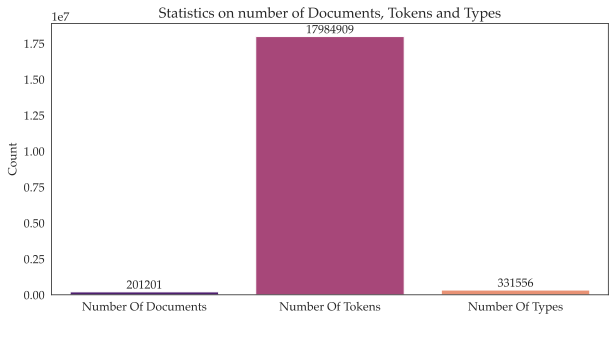

In [11]:
"""
Counts of number of documents, number of tokens and number of types before preprocessing
"""
corpus_flat = [token for document in complete_data['text'] for token in document.split()]

stats = pd.DataFrame({'lab':['Number Of Documents', 'Number Of Tokens', 'Number Of Types'], 'val':[len(complete_data), len(corpus_flat), len(c)]})

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax = sns.barplot(x="lab", y="val", data=stats,palette="magma")
ax.set_xlabel(" ")
ax.set_ylabel("Count")
ax.set_title("Statistics on number of Documents, Tokens and Types")
#ax.set_ylim(0,600000)
ind = np.arange(3)
for i in range(3):
    plt.annotate(str(round(stats.loc[i]['val'],1)), xy =(ind[i],stats.loc[i]['val']), weight = 'bold', ha='center', va='bottom')

    



<Figure size 432x288 with 0 Axes>

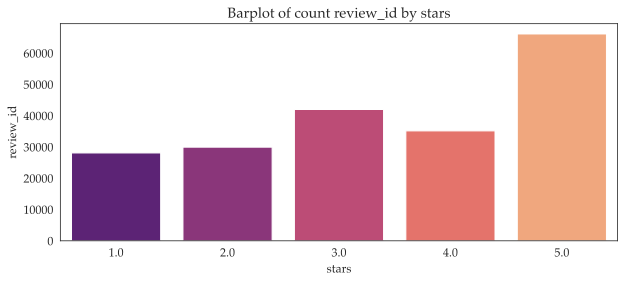

In [12]:
"""
Show the number of reviews by stars
"""

barplot_review_by_star = mean_bar_plot(complete_data,column = "stars",agg_column="review_id",agg_method="count")




We can see that despite an equal sampling of the sentiment, the data tends to be skewed towards 5 start restaurants. This can be observed indeed also in the complete dataset of 8.6 million reviews where an overwhelming number of reviews belongs to the 5 start group. Another large group consists of the mid-level reviews, which were labelled as negative sentiment due to the fact that we are looking at high-end restaurants where 3 stars would tend to be taken as a more negative effect. It is likely that these reviews, consisting most often of both positive and negative sentiment, will affect the performance in both classification and the language model itself. Indeed the results of the LM show some reviews to be containing this neutral sentiment that combines both some positive 

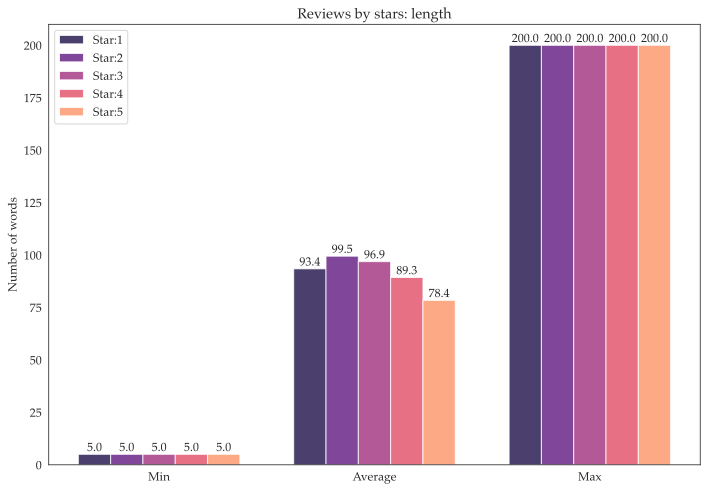

In [13]:
"""
Show some statistics: minimum, average and maximum length of each review per group (star) and total average length before preprocessing
Here it can be seen that in collecting the data a limit was already set: take those reviews which have less than 200 words and more than 5.
"""
def stats_plot(complete_data,column):
    plot = complete_data.groupby('stars').aggregate(['min','mean','max'])[[column]].reset_index()
    n_groups = 3
    data_1 = plot[column].loc[0].values
    data_2 = plot[column].loc[1].values
    data_3 = plot[column].loc[2].values
    data_4 = plot[column].loc[3].values
    data_5 = plot[column].loc[4].values

    # create plot
    fig, ax = plt.subplots(1,1, figsize = (10,7), facecolor = 'w')
    index = np.arange(n_groups)
    bar_width = 0.15
    opacity = 0.8

    rects1 = plt.bar(index, data_1, bar_width,
    alpha=opacity,
    color=palette[3],
    label='Star:1')
    for i in range(n_groups):
        plt.annotate(str(round(data_1[i],1)), xy =(index[i],data_1[i]), weight = 'bold', ha='center', va='bottom')

    rects2 = plt.bar(index + bar_width, data_2, bar_width,
    alpha=opacity,
    color=palette[8],
    label='Star:2')
    for i in range(n_groups):
        plt.annotate(str(round(data_2[i],1)), xy =(index[i] + bar_width,data_2[i]), weight = 'bold', ha='center', va='bottom')

    rects2 = plt.bar(index + 2*bar_width, data_3, bar_width,
    alpha=opacity,
    color=palette[13],
    label='Star:3')
    for i in range(n_groups):
        plt.annotate(str(round(data_3[i],1)), xy =(index[i] + 2* bar_width,data_3[i]), weight = 'bold', ha='center', va='bottom')

    rects3 = plt.bar(index + 3*bar_width, data_4, bar_width,
    alpha=opacity,
    color=palette[18],
    label='Star:4')
    for i in range(n_groups):
        plt.annotate(str(round(data_4[i],1)), xy =(index[i] + 3* bar_width,data_4[i]), weight = 'bold', ha='center', va='bottom')

    rects5 = plt.bar(index + 4*bar_width, data_5, bar_width,
    alpha=opacity,
    color=palette[23],
    label='Star:5')
    for i in range(n_groups):
        plt.annotate(str(round(data_5[i],1)), xy =(index[i] + 4* bar_width,data_5[i]), weight = 'bold', ha='center', va='bottom')


    plt.ylabel('Number of words')
    plt.title('Reviews by stars: length')
    plt.xticks(index + 0.3, ('Min', 'Average', 'Max'))

    plt.legend()
    plt.tight_layout()

    
stats_plot(complete_data,"length_uncleaned")



We can see that generally the length of reviews are pretty similar, it is however noticeable that good reviews tend to be written shorter. This could be a result of the fact that when people are satisfied, they simply express this without going into much detail. Indeed the longest avergae review length is at 2-3 stars, arguably a group of people that will write detailled reports of their complaints with the restaurant. 

### Section 1.2: Preprocessing <a class="anchor" id="section_1_2"></a>

As our aim is to evaluate the performance of two language models, generate fake reviews and see how do they generalize. We need to preprocess the test in different ways: we will clean the original text in order to create a version for tfidf vectorization, topic models and clustering scopes and one for the language model (where there will be almost no cleaning). In fact for the language model, we simply remove all special characters apart from: Dot, Comma, Exclamationmark and Questionmark. Additionally only words that appear more than once in the vocabulary will be considered for training to avoid uncommon spelling mistakes.<br>

As it can be seen in the tokenization part, We are not keeping PROPN because, as these are restaurant specific reviews, we do not want our learning process to memorize restaurant names. 
In this way we are able to generalize on the real content of the review independently of the restaurant chosen.

All the preprocessing steps are already saved in the sql databse, therefore the will be commented out in the next cells.


In [14]:
"""
General functions for preprocessing.
sub: removes reg ex patters from reviews
preprocess_tfidf: tokenization: we only keep content words: ADJ,VERB,NOUN,ADV. 
cleaning:  regex function
"""

def sub(data,column,out_column,pattern = "\n+",sub = ""):
    pattern = re.compile(pattern)
    data[out_column] = data[column].apply(lambda x: re.sub(pattern,sub,x))
    
def preprocess_tfidf(document):
    return " ".join([token.lemma_ for token in nlp(document) if token.pos_ in ["ADJ","VERB","NOUN","ADV"]])


def cleaning(document):
    pattern = r"[\w']+|[.,!?;]"
    return " ".join(re.findall(pattern,document))

In [15]:
"""
Preprocess text for language model
cleaning_for_lm: apply regex function, we substitute the punctuation with their name and we drop all the other special characters that we do not substitute
"""


def cleaning_for_lm(data):
    sub(data,column = "text_lm",out_column = "text_lm",sub = ".")
    sub(data,column = "text_lm",out_column = "text_lm",pattern = "\.+\s*\.*",sub = " FULLSTOP ")
    sub(data,column = "text_lm",out_column = "text_lm",pattern = "\?+",sub = " QUESTIONMARK ")
    sub(data,column = "text_lm",out_column = "text_lm",pattern = "!+",sub = " EXCLAMATION ")
    sub(data,column = "text_lm",out_column = "text_lm",pattern = ",+",sub = " COMMA ")
    data["text_lm"] = data["text_lm"].apply(cleaning)
    return data


#complete_data["text_lm"] = complete_data["text"].str.lower()
#complete_data = cleaning_for_lm(complete_data)

In [16]:
"""
Preprocess text for topic models, tfidf vectorization, doc2vec and clustering
"""

#complete_data["text_tfidf"] = complete_data["text_lm"].apply(preprocess_tfidf)


'\nPreprocess text for topic models, tfidf vectorization, doc2vec and clustering\n'

In [17]:
"""
The dataset is composed of other languages - we filter only using the english restaurant reviews
"""

#complete_data["language"] = complete_data["text"].apply(detect)
#complete_data = complete_data.loc[complete_data["language"] == "en"].reset_index(drop = True)

'\nThe dataset is composed of other languages - we filter only using the english restaurant reviews\n'

In [18]:
"""
Further Cleaning
"""
sub(complete_data,column = "text_tfidf",out_column = "text_tfidf",pattern = "[^a-z\s_]",sub = "")
sub(complete_data,column = "text_tfidf",out_column = "text_tfidf",pattern = "fullstop\s*|questionmark\s*|exclamation\s*|comma\s*",sub = "")


#### Preprocessing Collocations: 
Find collocations which have a score greater than 80, which is the threshold value for which most collocations make sense for this dataset.

In [19]:
"""
Find collocations based on PMI in the tweets and create a dictionary to insert them in the dataframe
"""

def find_collocations(corpus,n = 50):
    stopwords_ = set(stopwords.words('english'))
    words = [word.lower() for document in corpus for word in document.split()
            if len(word) > 2
            and word not in stopwords_]

    finder = BigramCollocationFinder.from_words(words)
    bgm = BigramAssocMeasures()
    collocations = {bigram: pmi for bigram, pmi in finder.score_ngrams(bgm.mi_like)}
    
    string_collocations = [i for i in collocations if collocations[i] > n]

    dict_collocations = {i:i[0]+'_'+i[1] for i in string_collocations}

    manual_collocations = {('new','york'):'new_york'
                          }
    
    dict_collocations.update(manual_collocations)
    
    return dict_collocations

#dict_collocations = find_collocations(complete_data['text_tfidf'])
#
#
#
#f = pd.DataFrame.from_dict([dict_collocations]).T
#f = f.rename(columns = {0: 'collocations'})


#dict_collocations

In [20]:
"""
apply_collocations: manipulate the already cleaned tweet by replacing designated word with collocations
"""

def apply_collocations(sentence):
    res = sentence.lower()
    for b1,b2 in dict_collocations:
        res = res.replace("%s %s" % (b1 ,b2), "%s_%s" % (b1 ,b2))
    return res

#complete_data['collocations'] = complete_data['text_tfidf'].apply(apply_collocations)

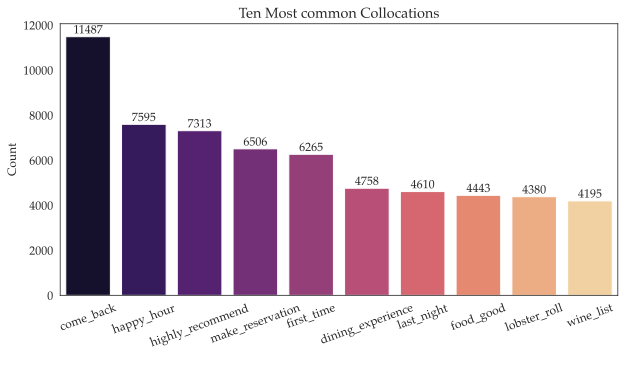

In [21]:


collocs = [token for document in complete_data['text_tfidf'] for token in document.split() if "_" in token]
"""
Show Ten Most Common Collocations
"""
c = Counter(collocs)
coll_data = {key: count for key,count in c.most_common(10)}
counts_coll = pd.DataFrame(c.most_common(10), columns = ['coll','times'])
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax = sns.barplot(x="coll", y="times", data= counts_coll, palette = "magma")
ax.set_xlabel(" ")
ax.set_ylabel("Count")
ax.set_title("Ten Most common Collocations")
plt.xticks(rotation = 20, size = 12)
ind = np.arange(10)
for i in range(10):
    plt.annotate(str(round(counts_coll.loc[i]['times'],1)), xy =(ind[i],counts_coll.loc[i]['times']), weight = 'bold', ha='center', va='bottom')



### Section 1.3: General Statistics on the final dataset after preprocessing <a class="anchor" id="section_1_3"></a>

In [22]:
df_plot = complete_data.loc[complete_data["language"] == "en"].reset_index(drop = True)


In [23]:
"""
Creating a field for the sentiment
"""
df_plot["Sentiment"] = "Negative"
df_plot.loc[df_plot["stars"].astype(np.float64) >3,"Sentiment"] = "Positive"

After having cleaned the dataset and prepared it for the analysis, general statistics on the dataset are given and a brief comparison with the before preprocessing dataset is presented.

<Figure size 432x288 with 0 Axes>

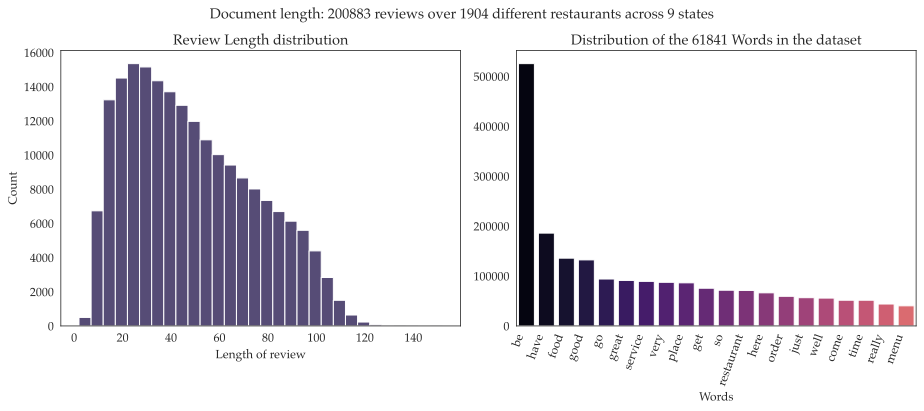

In [24]:
"""
Here we show the total number of documents after preprocessing and some general characteristics
"""
c = preprocess_plots(df_plot,"text_tfidf")



We can observe a strong decrease in the length of the reviews, although the overall shape of the distribution remains the same. Additionally, the most frequent words have disappeared and are instead now replaced by more restaurant related tokens. 

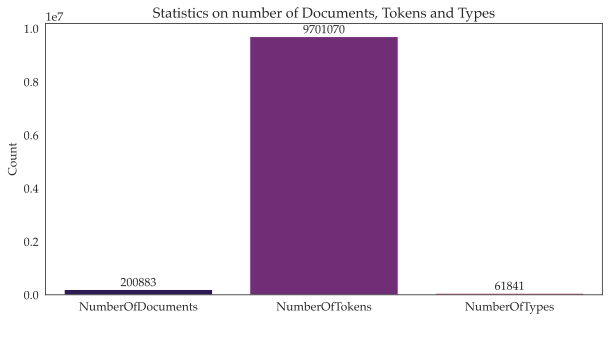

In [25]:
"""
Counts of number of documents, number of tokens and number of types after preprocessing
"""
corpus_flat = [token for document in df_plot['text_tfidf'] for token in document.split()]
#del c['fullstop']

stats = pd.DataFrame({'lab':['NumberOfDocuments', 'NumberOfTokens', 'NumberOfTypes'], 'val':[len(df_plot), len(corpus_flat), len(c)]})

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax = sns.barplot(x="lab", y="val", data=stats,palette = palette[4::6])
ax.set_xlabel(" ")
ax.set_ylabel("Count")
ax.set_title("Statistics on number of Documents, Tokens and Types")
#ax.set_ylim(0,600000)
ind = np.arange(3)
for i in range(3):
    plt.annotate(str(round(stats.loc[i]['val'],1)), xy =(ind[i],stats.loc[i]['val']), weight = 'bold', ha='center', va='bottom')


Comparison: we clearly see that the number of documents has diminished by hundredds of units, whereas tokens has shrinked by thousands of units and also the types have diminished consequently to the cleaning process. <br>
The frequencies for the first 1000 words are now plotted which as expected resemble the Zipf's law: very common in linguistics.

Text(0.5, 1.0, 'Frequency of Words')

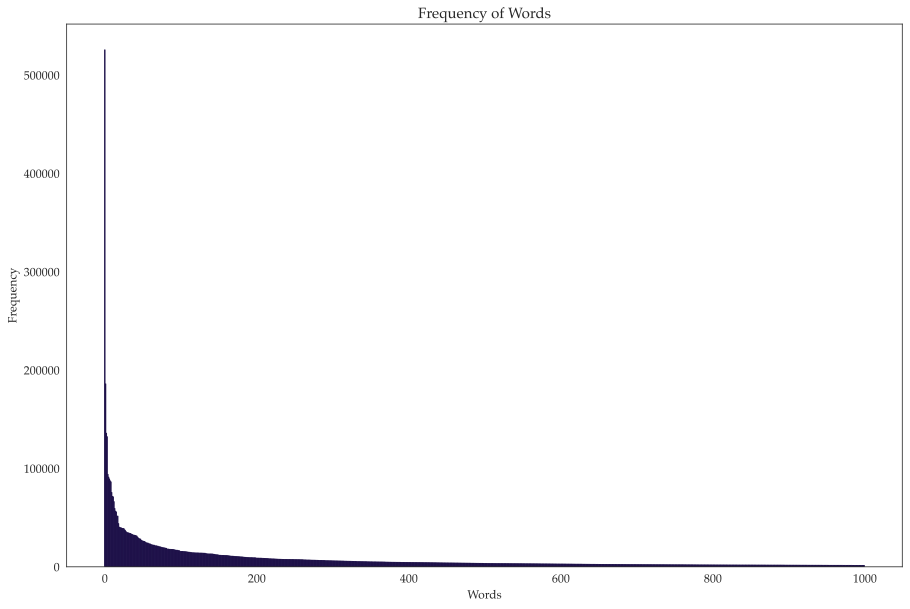

In [26]:
"""
Plot of first 1000 word frequencies: Zipf's (or Power law) distribution of tokenized version text
"""

most_common_words = c.most_common()
most_common_words = [i[1] for i in most_common_words]
most_common_df = pd.DataFrame(most_common_words, columns = ['frequency'])

fig, axs = plt.subplots(1,1, facecolor='w', figsize=(15,10))
most_common_df.reset_index(inplace = True)
axs.bar(most_common_df['index'][:1000],most_common_df['frequency'][:1000], color = palette[3], label = 'words', edgecolor = palette[3], width = 0.5)

plt.xlabel('Words')
plt.ylabel('Frequency')
axs.set_title("Frequency of Words", size = 15)



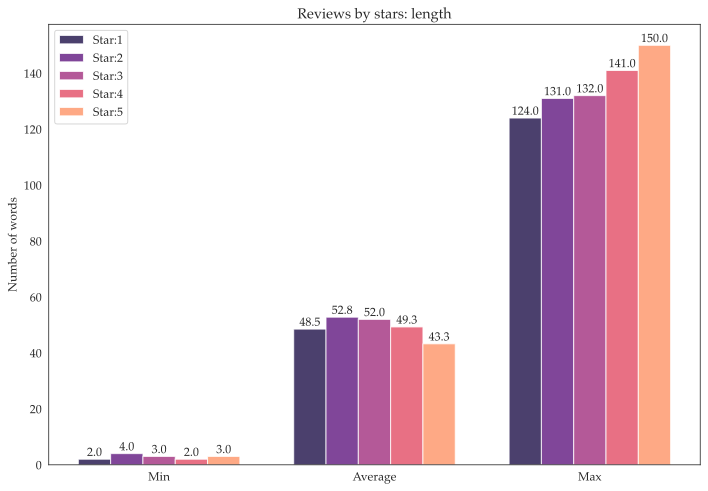

In [27]:
"""
Lets check the new average and max length of the reviews by star
"""

df_plot['length'] = df_plot['text_tfidf'].apply(compute_length)

stats_plot(df_plot,"length")



In [28]:
#this needs to be done with lemmas

"""
Most common word per star after cleaning. Here we show 5 most common words for star 5 and 1
"""

data_5 = df_plot[df_plot['stars'] == 5.0]
data_1 = df_plot[df_plot['stars'] == 1.0]

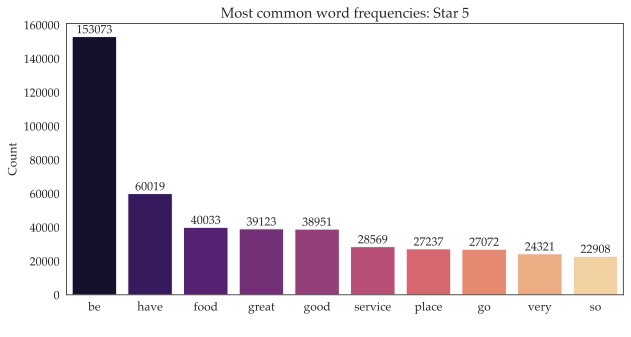

In [29]:
"""
Barchart most common word frequencies for star 5 after cleaning
"""

corpus_flat = [token for document in data_5['text_tfidf'] for token in document.split()]
data_5_comm = Counter(corpus_flat)
most_c = pd.DataFrame(data_5_comm.most_common()[:10], columns = ['word','frequency'])

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax = sns.barplot(x="word", y="frequency", data= most_c, palette = "magma")
ax.set_xlabel(" ")
ax.set_ylabel("Count")
ind = np.arange(len(most_c))
ax.set_title("Most common word frequencies: Star 5")
plt.xticks(ind, most_c['word'].values, rotation = 0, size = 12)
for i in range(len(most_c)):
    plt.annotate(str(round(most_c.loc[i]['frequency'],1)), xy =(ind[i],most_c.loc[i]['frequency']), weight = 'bold', ha='center', va='bottom')


## Section 1.4: Analysis <a class="anchor" id="section_1_4"></a>

### Subsection 1.4.1: Topic Models: LDA <a class="anchor" id="section_1_4_1"></a>

Considering 5 different set of restaurant reviews acoording to the number of stars, we now investigate what are the most discussed topics in each set of documents. Firstly, a topic model through LDA is proposed. The corpus on which topic model is runned is mainly based on <strong> content words: adjectives, nouns, adverbs and verbs </strong> in order to suggest more descriptive words for each set.

In [30]:
#Here maybe we want to do some more cleaning, like remove verbs or just leaving adjectives: depends on how nice are the topic

In [31]:
df_plot['topic_model'] = df_plot['text_tfidf']
instances = df_plot['topic_model'].apply(str.split).tolist()

In [32]:
"""
Create dictionary with information about frequencies and get rid of words which are at the extremes (in terms of frequency)
"""
instances = df_plot['topic_model'].apply(str.split).tolist()
print("creating dictionary", flush=True)

phrases = Phrases(instances, min_count= 20, threshold=1) 
#20 is the number that gives the most meaningful topics and gets rid of most non-informative concepts

instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)

dictionary.filter_extremes(no_below= 40, no_above= 0.8)
print(dictionary, flush=True)

creating dictionary
Dictionary(14709 unique tokens: ['authentic', 'be', 'bland', 'chicken', 'crispy']...)


In [33]:
"""
Translate corpus to IDs and trasform it into tfidf values
"""


print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]

print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)

model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [34]:
"""
Calibrate the number of topics according to their coherence values
"""

coherence_values = []



for num_topics in range(4, 10):
    model = LdaMulticore(corpus= model_corpus[:10000], 
                         id2word= dictionary, 
                         num_topics=num_topics, random_state=42)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances, 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances, 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

4 -1.298818235879674 0.43138071319924987
5 -1.309623264810768 0.4298843159767644
6 -1.318423698386838 0.4299307413587383
7 -1.3355452661009508 0.43424955770722923
8 -1.264611980420168 0.4318859496071794
9 -1.2988335740974157 0.4347944212094


FileNotFoundError: [Errno 2] No such file or directory: 'Images/TM_1.png'

<Figure size 936x288 with 0 Axes>

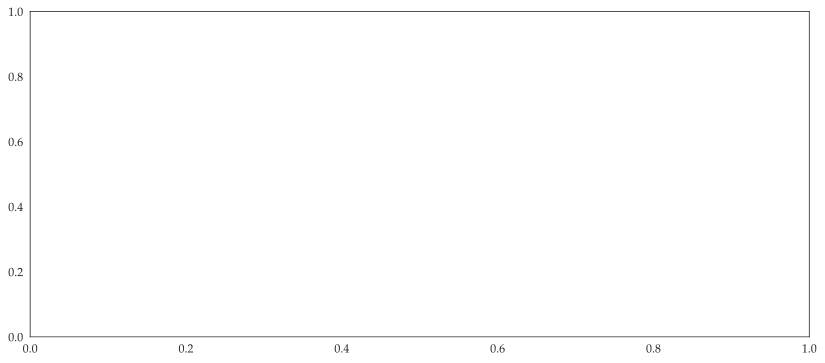

In [35]:
"""
Select the best number of topics based on cv coherence score
"""

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
fig.suptitle("Topic Evaluation Plot")
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,10));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,10));


#plt.savefig("Images/TM_1.png")
image_reader("Images/TM_1.png")

In [ ]:
"""
Select the best number of topics based on UMass score
"""
#num_topics = int(scores.loc[np.argmax(scores['UMass'])]['num_topics'])
num_topics = 8

In [ ]:
"""
Train Lda model
"""
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics= num_topics, 
                     corpus= model_corpus, 
                     id2word= dictionary, 
                     #passes= num_passes, 
                     #chunksize= chunk_size, 
                     random_state= 42
                    )
    
print("done in {}".format(time.time()-start), flush=True)


In [ ]:
"""
Print the topics found
"""

topic_corpus = model[model_corpus]
topic_sep = re.compile("0\.[0-9]{3}\*")
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=6)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

In [ ]:
"""
Investigate average topic scores for each star
"""

target_category = 'stars'

scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(df_plot['topic_model']))]

topic_distros = pd.DataFrame(data=scores, columns=descriptors)

topic_distros['category'] = df_plot[target_category]

In [ ]:
topic_distros.category = topic_distros.category.astype(str)
topic_distros.head()

In [ ]:
"""
Plot LDA
"""
fig, ax = plt.subplots(figsize=(13, 6)) # set graph size

# aggregate topics by categories
aggregate_by_category = topic_distros[topic_distros.category.isin('1.0 2.0 3.0 4.0 5.0'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()

# plot the graph
aggregate_by_category.plot.bar(ax=ax, cmap = "magma")
index = np.arange(5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 18})
ax.set_title("Topics by stars",size = 20)
ax.set_xlabel("")
ax.set_ylabel("Proportion", size = 18)
plt.xticks(ticks = index, rotation = 0, size = 20)




In [ ]:
# Comment here
import matplotlib.ticker as mticker


def plot_importance_plot(data, num_topics, fig_rows, fig_columns):
    sns.set_style("white")
    
    def return_topic_importance(data, num_topics):
        words=[word for line in data for word in str(line).split(' ')]
        counter=Counter(words)
        output=[]
        for i in range(num_topics):
            for topic in model.show_topic(i):
                output.append([topic[0], i, topic[1], counter[topic[0]]])
        return pd.DataFrame(output, columns=['word', 'topic', 'weight', 'word_count'])
    
    topic_importance = return_topic_importance(data,num_topics)
    
    #plot the above topic importance dataframe per topic category
    cols = palette[4::4]
    fig, axes = plt.subplots(fig_rows,fig_columns,figsize=(14,14), sharey=True)
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word',height='word_count', data=topic_importance[topic_importance['topic']==i],color=cols[i],
           label='Word Count', width=0.5, alpha=0.3)
        ax_twin = ax.twinx()
        ax_twin.bar(x='word',height='weight', data=topic_importance[topic_importance['topic']==i],color=cols[i],
           label='Topic importance', width=0.2 )
        ax.set_xticklabels(topic_importance[topic_importance['topic']==i]['word'],rotation=70, horizontalalignment= 'right')

        #plt.xticks(np.arange(10),topic_importance[topic_importance['topic']==i]['word'])
        ax.legend(loc='upper left'); 
        ax_twin.legend(loc='upper right')
        ax_twin.set_ylim(0, 0.030)
        ax.set_title(f'Topic {i+1}', color=cols[i])
    fig.tight_layout(rect = [0,0.03,1,0.95]) 
    fig.suptitle('Barplot of word count and importance per each topic category')
    plt.show()





plot_importance_plot(df_plot['topic_model'], 6,3,2)



Comment on Topic Models: 


As we can see from the graphs, the most common topic for rating 1 is wait,time  which is suggesting that customers who had to wait a lot of time to be served rated the lowest. This is also the most common topic of the rating 2, suggesting that this is one of the main driver for rating an high end restaurant with low scores. Instead focusing on star 4-5 we can see that, as expected, the most common topics are great, delicious place. It has to be noticed that the "positive" topics are overlapping, which may suggest that they are capturing different type of information.

However it should also be observed that almost all of the topics have positive adjectives in them. This may be explained by two things: 

1. The data is generally consisting of a large number of positive reviews. 
2. Even the negative reviews may contain a lot of words such as great. In fact many writers would say "not great". This provides a shortcoming of the topic model to capture this relationship, an issue which could not even be resolved by including collocations. 

### Subsection 1.4.1: Word2Vec: Ensemble Word Embeddings <a class="anchor" id="section_1_4_1"></a>

Five word2vec models are runned, ensembled and averaged.

In [ ]:
"""
Basic Input format transformations for later use
"""
df_plot['stars'] = df_plot['stars'].astype(str)
df_plot['text_w2v'] = df_plot['text_tfidf'].str.split()

In [ ]:
"""
This first word2vec is runned to extract the shape of the matrix on which we will be averaging.
Here notice input is a list of lists
"""

from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION

corpus = list(df_plot['text_tfidf'].drop_duplicates().str.split().values) #input is a list of lists

w2v_model = Word2Vec(size=100, #parameter that usually works better
                     window= 40, #as average length of restaurant review is 70
                     sample=0.00001 ,
                     iter = 500, 
                     negative= 5,
                     min_count= 40, #choice of parameter delivers the most interesting results
                     workers=-1,
                     hs= 1
                        )
w2v_model.build_vocab(corpus)

w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

In [ ]:
"""
train_n_w2v_and_average: train n word2vec models on the entire corpus with different parameters and average the results
"""
def train_w2v_and_average(w2v,n, corpus):
    
    m = [w2v.wv.vectors]
    
    for j in range(n):
        w2v_model = Word2Vec(size=100, #parameter that usually works better with word embeddings
                             window= 40, #increase window size at each iteration
                             sample=0.00001 ,
                             iter = 500, 
                             negative= 5, #change parameters at each iteration
                             min_count= 40, #delivers the most interesting results compared to other values of min_count
                             workers=-1,
                             hs= 0, 
                             seed = np.random.randint(0,100) #change seed each time
        )
        

        
        w2v_model.build_vocab(corpus)

        w2v_model.train(corpus, total_examples=w2v.corpus_count, epochs=w2v.epochs)
        m.append(w2v_model.wv.vectors) #collect each matrix
    w2v_model.wv.vectors = np.mean(m,axis = 0) #here I assign the averaged matrix to the previous model
    return w2v_model


In [ ]:
"""
5 different word2vec have been trained and then the results are averaged
"""

w2v_model = train_w2v_and_average(w2v_model,5, corpus)

In [ ]:
"""
Most similar words to restaurants specific keywords: quality, food, service, experience
"""

def most_similar():
    def extract(word):
        l = w2v_model.wv.most_similar(word, topn = 5)
        nice = [i[0] for i in l]
        return nice
    for j in ['quality','food','service','dessert']:
        print("Most Similar to " + j +" :", extract(j))
    
most_similar()

### Subsection 1.4.1: Doc2Vec: Document Word Embeddings <a class="anchor" id="section_1_4_1"></a>

Doc2vec is performed to further inspect the dataset: how similar are restaurant reviews with different ratings and how really far are reviews with opposite ratings. <br>
Later, we will extract the most 100 similar words to each star rating, take their word2vec representation and apply k-means clustering algorithm.

In [ ]:
"""
With this version of Document Embeddings, each review related to a specific rating has been tagged.
The question we aim to answer is related to how similar are restaurant reviews of different ratings.
"""

from gensim.models.doc2vec import TaggedDocument


corpus_m = []
for j in range(len(df_plot)):
    label = df_plot['stars'].loc[j]
    text = df_plot['text_w2v'].loc[j]
    corpus_m.append(TaggedDocument(words = text, tags = [label]))

In [ ]:
"""
Doc2Vec model is trained
"""

from gensim.models import Doc2Vec


d2v_model = Doc2Vec(vector_size=300, 
                    window= 35, #as average length for each restaurant review is 60
                    hs=0,
                    sample=0.0001,
                    negative= 5, #based on documentation I choose default value
                    min_count= 40, #with this parameter we can avoid most of the extreme words
                    workers= -1,
                    epochs=500,
                    dm=0)

# build the vocabulary
d2v_model.build_vocab(corpus_m)

# train the model
d2v_model.train(corpus_m, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [ ]:
"""
How similar are the restaurant reviews with the highest star rating reviews compared to the others
"""

target_doc = '5.0'


similar_docs = d2v_model.docvecs.most_similar(target_doc, topn=5)
print(similar_docs)

As expected we can see that they are more similar to 4 and 3 stars review and "distant" from 1 and 2 stars review.

### Most similar words to each rating

In [ ]:
"""
Define cosine similarity function for further use
"""
from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))


In [ ]:
"""
Extraction and clustering of most 100 similar words to each rating.
collect_most_similar_words: compute the cosine similarity between vector of rating representation and all the other
words in the vocabulary and keeps only the highest 5 words by positive cosine similarity. 
"""

d2v_indices = {word: d2v_model.wv.vocab[word].index for word in d2v_model.wv.vocab}
words = [i for i in d2v_indices]
coord_words = d2v_model.wv[words]

def collect_most_similar_words(X):
    ratings = list(df_plot.stars.unique())
    c = {}
    for i in ratings:
        rating = d2v_model.docvecs[i]
        cosine_sim_values = {}
        for j in range(len(X)):
            cosine_sim_values[words[j]] = cos_sim(rating, X[j])
        cosine_sim_values = dict(sorted(cosine_sim_values.items(), key=lambda x: x[1], reverse=True))
        l = list(cosine_sim_values.items())[:5]
        ms_words = [t[0] for t in l]
        c[i] = ms_words
    return c


In [ ]:
"""
Collect the most similar 
"""

most_similar_words = collect_most_similar_words(coord_words)

In [ ]:
most_similar_words

### Clustering of reviews: K-MEANS

Going ahead with our descriptive tasks, what we want to focus now is: by considering these restaurant reviews per se (without looking at the rating), what is the optimal number of clusters? Does it make sense to regroup reviews belonging to different ratings into more comprehensive groups?

In [ ]:
"""
We perform this operation on a stratified sample, in order to speed up the clustering and then generalize on the whole dataset
"""

df_sample, _ = train_test_split(df_plot, test_size=0.92, stratify=df_plot[['stars']])
df_sample = df_sample.reset_index(drop=True)

In [ ]:
"""
Create the corpus where each review is considered as an unique document
"""

LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in df_sample['text_w2v'].values:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print("Number of texts processed: ", j)

In [ ]:
"""
A doc2vec model is trained
"""

d2v_model = Doc2Vec(all_content_train, 
                    vector_size = 300,
                    window = 40, #as average length for each review is 60
                    min_count = 30, #best value for meaningful results
                    workers=4, 
                    dm = 0, 
                    epochs = 200)


d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

X = d2v_model.docvecs.vectors_docs

In [ ]:
"""
Learn best number of clusters for kmeans using agg_clustering initialized centroids - measure silhoutte score
"""
#Speeding up Clustering

pca = PCA(50).fit(d2v_model.docvecs.vectors_docs)
X = pca.transform(d2v_model.docvecs.vectors_docs)

silhouettes = []

K = range(3, 7)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids_k = agg_clustering.fit_predict(X)
    agg_centroids = np.array([X[[i for i, v in enumerate(agg_cluster_ids_k) if v == k]].mean(axis=0) for k in range(c)])

    kmeans_clustering = KMeans(n_clusters= c, init = agg_centroids , n_init = 1)
    kmeans_ids = kmeans_clustering.fit_predict(X)
    score = silhouette_score(X, kmeans_ids)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal K', size = 15)

plt.savefig("Images/TM_5.png")
image_reader("Images/TM_5.png")

In [ ]:
"""
We use three clusters in order to understand whether we can see """
n_c = 3
n_c

In [ ]:
"""
K-means with agg_clustering initialized centroids and best number of clusters
"""
X = d2v_model.docvecs.vectors_docs
agg_clustering = AgglomerativeClustering(n_clusters=n_c)
agg_cluster_ids_k = agg_clustering.fit_predict(X)
agg_centroids = np.array([X[[i for i, v in enumerate(agg_cluster_ids_k) if v == k]].mean(axis=0) for k in range(n_c)])


km = KMeans(n_clusters= n_c , init= agg_centroids, n_init = 1)

labels_kmeans = km.fit_predict(X)

In [ ]:
"""
Reduce dimensionality for plotting, KMEANS
"""
from matplotlib.lines import Line2D 

df_sample['label'] = labels_kmeans
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#0FF000"]
df_sample['color'] = df_sample['label'].apply(lambda x: label1[x])
pca = PCA(n_components= 2).fit(X)
datapoint = pca.transform(X)
df_sample['data_0'] = datapoint[:,0]
df_sample['data_1'] = datapoint[:,1]

ind = np.random.choice(np.arange(len(datapoint)), size = 500) #only consider 3000 observation for better viz

df_sample_plot = df_sample.loc[ind]

star_1 = df_sample_plot[df_sample_plot['stars'] == '1.0']
star_2 = df_sample_plot[df_sample_plot['stars'] == '2.0']
star_3 = df_sample_plot[df_sample_plot['stars'] == '3.0']
star_4 = df_sample_plot[df_sample_plot['stars'] == '4.0']
star_5 = df_sample_plot[df_sample_plot['stars'] == '5.0']
"""
Plot of clusters: chromatic features maintained - KMEANS
"""

label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#0FF000"]


fig, ax3 = plt.subplots(1,1, figsize = (10,10))

datapoint = datapoint[ind]
ax3.scatter(star_1['data_0'].values, star_1['data_1'].values, marker = 'o', c= star_1['color'].values)
ax3.scatter(star_2['data_0'].values, star_2['data_1'].values, marker = 'o', c= star_2['color'].values)
ax3.scatter(star_3['data_0'].values, star_3['data_1'].values, marker = 'o', c= star_3['color'].values)
ax3.scatter(star_4['data_0'].values, star_4['data_1'].values, marker = 'x', c= star_4['color'].values)
ax3.scatter(star_5['data_0'].values, star_5['data_1'].values, marker = 'x', c= star_5['color'].values)




centroidpoint = pca.transform(agg_centroids)
ax3.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker="^", s=150, c="#000000")
ax3.set_title("Kmeans Clustering of Most Similar Words", size = 15)
ax3.axes.xaxis.set_ticklabels([])
ax3.axes.yaxis.set_ticklabels([])

for_l =  [Line2D([0], [0], marker='o', color=label1[0], label='Scatter',markerfacecolor=label1[0], markersize=10),
         Line2D([0], [0], marker='o', color=label1[1], label='Scatter',markerfacecolor=label1[1], markersize=10),
         Line2D([0], [0], marker='o', color=label1[2], label='Scatter',markerfacecolor=label1[2], markersize=10)]

ax3.legend(for_l,['Cluster 0','Cluster 1','Cluster 2'],prop={'size': 15})


plt.savefig("Images/TM_6.png")

From this reduced example, as expected it can be seen that mostly reviews with rating 4-5 are clustered together identified by the crosses, whereas those negative and mediocre (1-2-3) identified by the circles are also usually grouped together.
Therefore for this reason we decided to group restaurants reviews which had a rating of 4-5 as positive reviews and those that have a rating of 1-2-3 as negative reviews.

# Chapter 2: Language Models <a class="anchor" id="chapter_2"></a>

As the purpose of this study is to gain a deeper understanding of the performance of a language model, measured in the quality of the fake reviews generated. In this section we implement three different language models: one based on the Structured Perceptron, a Word-Based LSTMl and a Char Based RNN. As explained before we will then select the two best language models and generate two sets of 4k reviews which will be later manually annotated.

In [ ]:
"""
Train Test split: we split the dataset
Notice that we add START and END strings to each review in the training dataset for the language model
"""

from sklearn.model_selection import train_test_split

#train_lm, remainder = train_test_split(df_plot, test_size = 2/20)
#train_classify,test_classify = train_test_split(remainder, test_size = 3/5)
#train_lm = train_lm.reset_index(drop = True)

#train_lm["text_lm"] = train_lm["text_lm"].apply(lambda x: "START " + x + " END")

In the analysis, sequential rather than fuctional model will be implemented since it is expected for the model to be connected to just one previous 
and one following layer and it is not desired to have multiple inputs or outputs.

In [ ]:
#For now we keep this, but we'll later change

train_lm = data
train_classify = df_later_train
test_classify = df_later_test

### Section 2.1: Structured Perceptron <a class="anchor" id="section_2_1"></a>

In this section we have adapted the structured perceptron class to a language model. The rewritten class can be found in the Perceptron.py file. 


In [ ]:
"""
Given the limited potential power of the structured perceptron we are forced to train it on a limited number of reviews (2000), but this allows us to find the optimal number of features

"""

import pandas as pd
from collections import defaultdict, Counter
import json
import re
import numpy as np
import sys
import pickle
import random
from keras.preprocessing.text import Tokenizer
from Perceptron import StructuredPerceptron

train = list(pd.read_csv("Data/perceptron_train.csv", encoding='latin-1'))
test = list(pd.read_csv("Data/perceptron_test.csv", encoding='latin-1'))
np.set_printoptions(precision=2)


In [ ]:
"""
At this stage we need to prepare the dataset to feed to the Language Model. The best result were delivered using a 2-gram based dataset structured as follows

(I, did)         -  really
(did, really)    -  enjoy
(really, enjoy)  -  the
(enjoy, the)     -  pudding

The adaption from the code provided consisted in changing the way the code takes the input which before takes a word and now takes tuples, but mainly in the types of features
that were used

"""


def tokenize(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    encoded = tokenizer.texts_to_sequences(data)
    sequences = [[encoded[j][i-2:i+1] for i in range(2, len(encoded[j]))] for j in range(len(encoded))]
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    x = [list(zip(map(lambda i : reverse_word_map[i], np.array(seq)[:, 0]), map(lambda i : reverse_word_map[i], np.array(seq)[:,1]))) for seq in sequences if len(np.array(seq).shape) > 1]
    y = [list(map(lambda i : reverse_word_map[i], np.array(seq)[:,2])) for seq in sequences if len(np.array(seq).shape) > 1]
    return x, y

X_train, y_train = tokenize(train)
X_test, y_test = tokenize(test)

#### Training of the perceptron

#### !!! DO NOT EXECUTE THE BELOW !!!
The following sections show the code to train a model, nevertheless given the long runtime it is advised to load a pre-trained model in the subsequent code section to the one below

In [ ]:
"""
The model has 64% accuracy on the test
"""

#sp = StructuredPerceptron()
#sp.fit(X_train, y_train, X_test, y_test, iterations=1
#       )

In [ ]:
"""
Saved the weights and the feature_name -> tags -> weight dictionaries into a pickle that will be used to avoid running the model
"""
from collections import defaultdict

sp = StructuredPerceptron()


with open('Neural_Models/perceptron.pickle', 'rb') as model:
    try:
        parameters = pickle.load(model)
    except IOError:
        msg = ("No such model file.")
        raise MissingCorpusError(msg)

    feature_weights, tag_dict, tags = parameters
    sp.tags = tags


    sp.feature_weights = defaultdict(lambda: defaultdict(float))
    sp.tag_dict = defaultdict(set)
    
    sp.feature_weights.update(feature_weights)
    sp.tag_dict.update(tag_dict)
    print("done", file=sys.stderr)

#### Text Generation

In [ ]:
l = test[5:10]

In [ ]:
"""
This is the text generated using the sentence above which uses the features weights on which the model was trained on

"""
for text in l:

    print(" ".join(sp.predict(list(zip(text.split(), " ".join(text.split()[1:] + ["END"]).split())))))
    print("")

As we can see the perceptron is not during great at predicting a real sentence. This is likely due to the large number of features needed to predict, which forces it to train it on very little data. Indeed only a subsample of 1200 reviews was used for to train this model. The Character Based RNN and Word based LSTM will likely provide much better results and have been trained on the entire training set. 

### Section 2.2: Character Based RNN <a class="anchor" id="section_2_2"></a>

We now use a Recurrent Neural Network as an alternative language model to generate artificial reviews using 
the same training set (180k) on which we generated reviews using the LSTM.


(remove the text of the cell below in triple strings, it is the same text)

In [ ]:
"""
We now use a Recurrent Neural Network as an alternative language model to generate artificial reviews using 
the same training set (180k) on which we generated reviews using the LSTM
"""


import sys
from database import Database
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import os
import time

train_LM = train_lm


In [ ]:
"""
We join the review with the END token to signal the end of the review and the beginning of the next one

"""

text = "END".join(train_LM['text'].to_list())

In [ ]:
"""
Length of vocabulary which is now characters 
"""

vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

In [ ]:
"""
Convert each character into numeric ID

"""


ids_from_chars = preprocessing.StringLookup(
    vocabulary=list(vocab))

all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
"""
Reverse-engineer the process to obtain chars from ids
"""

chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True)

def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

In [ ]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
    print(chars_from_ids(seq))

In [ ]:
"""
Create equal length sequences as according to a char-based model
"""

for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
"""
The input is just a normal review, while the target is just the same review shifted by a character
"""


for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

In [ ]:
input_example.shape

In [ ]:
BATCH_SIZE = 128

"""
Buffer size to shuffle the dataset
"""


BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

In [ ]:
"""
We use the same number of embedding dimensions as we used in the LSTM embedding
"""


vocab_size = len(vocab)

embedding_dim = 100

rnn_units = 1024

In [ ]:
"""
We construct a Recurrent Neural Network using an embedding of size 100 and 1024 units
"""


class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        
        
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                     return_sequences=True,
                                     return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)
  
    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)
  
        if return_state:
            return x, states
        else:
            return x

In [ ]:
model = MyModel(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

In [ ]:
model.summary()

In [ ]:
#loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
#model.compile(optimizer='adam', loss=loss)

In [ ]:
"""
Three epochs are chosen to be the optimal ones as training loss doesn't decrease much after this

"""

EPOCHS = 3

#### !!! DO NOT EXECUTE THE BELOW !!!
The following sections show the code to train a model, nevertheless given the long runtime it is advised to load at the result in the next section

In [ ]:
#history = model.fit(dataset, epochs=EPOCHS)

In [ ]:
"""
Given the beginning of all sentences one wants the generate 
(which we predefined to END as it signals the passage between one sentence and another
this class generates the next char for all the sentences) and all the sentences would have now equal length cause the sentences are generated 
horizontally. Therefore what we do is stopping each sentence at the first END
"""


class OneStep(tf.keras.Model):
    
    
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars
    
        # Create a mask to prevent "" or "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['', '[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)
    
    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convert strings to token IDs.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()

        # Run the model.
        # predicted_logits.shape is [batch, char, next_char_logits]
        predicted_logits, states = self.model(inputs=input_ids, states=states,
                                              return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
        predicted_logits = predicted_logits + self.prediction_mask

        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Convert from token ids to characters
        predicted_chars = self.chars_from_ids(predicted_ids)

        # Return the characters and model state.
        return predicted_chars, states

Now, let's generate 4000 reviews that will be used as a training dataset into various classification algorithms in order to asses the reliability of the language model. Here, we report the function with which we generated the fake reviews dataset. As this dataset has been annotated manually we will import it and do not actually generate them in the notebook.

### Section 2.3: Word Based LSTM <a class="anchor" id="section_2_3"></a>

Lastly, long short-term memory model (LSTM) is devised, which allows for the cycling of information within the network while solving the inadequacies of the standard RNN in modeling long-range contexts. Such structure results in a superior performance that can obtained in particular for tasks with large vocabulary size. Hence, given the large amount of data, we expect this model to perform the best in generating language.


<br> In order to implement LSTM using keras library, it is essential to define the maximum size of the vocabulary of words that will be utilized to train the algorithm. The below function implements an approach that counts the number of distinct words in all the reviews, while taking into consideration only those words that appear at least twice across all entries.

In [ ]:
counts_lm = Counter([token for document in train_lm["text_lm"] for token in document.split()])
max_vocab = len([i for i in counts_lm.values() if i >=2])
max_vocab

In the analysis, sequential rather than fuctional model will be implemented since it is expected for the model to be connected to just one previous 
and one following layer and it is not desired to have multiple inputs or outputs.

In [ ]:
"""
Import the libraries to be used in building the model
"""
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dropout, LSTM, InputLayer
from keras.layers.core import Dense, Activation
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [ ]:

tokenizer = Tokenizer(num_words = max_vocab,lower = False)

def token_processor(reviews,tokenizer):
    
    """
    fit the tokens on the training set
    """
    tokenizer.fit_on_texts(reviews)

    """
    Get integer representations of all words in the training set
    """
    review2int = tokenizer.texts_to_sequences(reviews)

    """
    The LSTM requires all inputs to be of the same length, thus post-padding is implemented on all the sequences. Post rather than post-padding is applied, since the model,once 
    being trained, is expected to generate new sentences from the scratch, while returning the state of the output for each input state in the given time step. 
    Thus, the input fed into the pre-trained model must have the following structure to succeed in sensible sentence generation: START, 0,.....,0,0
    """
    review2int_padded = pad_sequences(review2int,padding = "post")

    """
    Get Inputs and Lables arrays. While inputs always consist of the full review but the last word (END), the labels to be predicted hold the whole review but the first word (START) 
    """ 
    Inputs,Labels = review2int_padded[:,:-1],review2int_padded[:,1:]

    """
    Turn Labels into encoded matrix representations. This step is omitted due to the immerse memory requirements that are necessary for the vast vocabulary size in use
    and 'sparse_categorical_crossentropy' rather than 'categorical_crossentropy' loss function is applied later in the model to account for this fact.
    """
    #Labels = to_categorical(Labels, max_vocab+1)

    return Inputs,Labels

In [ ]:
Inputs, Labels = token_processor(train_lm["text_lm"],tokenizer)

"""
Define the expected length of the input that will be fed into the algorithm. 
"""
MAX_LENGTH = Labels.shape[1]
MAX_LENGTH

In [ ]:
"""
The dimension of the dense embeddings that will be fed into LSTM model
"""
vec_size = 100 

"""
Function that creates the sequentional LSTM model
"""
def create_model(max_vocab,vec_size,input_length):
    
    
    model = Sequential()
    model.add(Embedding(max_vocab+1, #define the size of the vocabulary
                        vec_size, # dimension of the dense embedding
                        input_length=input_length, # specify the expected shape of the input
                        name='embeddings'))
    model.add(LSTM(units=vec_size*2 , #dimensionality of the output space.
                                activation="tanh",
                                recurrent_activation="sigmoid",
                                use_bias=True,
                                kernel_initializer="glorot_uniform",
                                recurrent_initializer="orthogonal",
                                return_sequences=True))    #Since our input and output are of the same lenght and the model 
                                                        #should return the state of the output for each input state in the given time step,
                                                          #we set the parameter return_sequences equal to true 
    """
    Multiple dropout rate have been tested to arrive at the optimal value of 0.1
    """
    model.add(Dropout(0.1, name='dropout')) 
    model.add(Dense(units=max_vocab+1,name='output')) 
    model.add(Activation("softmax"))
    """
    We include an accuracy metrics even through it is not neccessarily interesting to analyze this measure given the task at hand that is not aiming at exactly replicating the input 
    but rather creating novel reviews.
    """
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model

model_positive = create_model(max_vocab,vec_size,MAX_LENGTH)

#### !!! DO NOT EXECUTE THE BELOW !!!
The following sections show the code to train a model, nevertheless given the long runtime it is advised to load a pre-trained model in the subsequent code section to the one below

### Load a pretrained model

In [ ]:
from tensorflow import keras
history_model = keras.models.load_model('Neural_Models/LSTM_Final.h5')

"""
Check its architecture
"""
history_model.summary()

### Generate new reviews

The below code section implements a function capable of generating new sentences out of scratch. At each time step, a subsequent word is sampled from the word probabilities obtained as an prediction output of the LSTM model. It is essential to sample words rather than choosing the most likely word in order to avoid getting stuck in the loops of word repetition. Furthermore, we incorporate a temperature into the sampling process. Lower temperatures make the model increasingly confident in its top choices, while temperatures greater than 1 decrease confidence. 

In [ ]:
def plot_changing_temp(seed_list):

    seed_list = tokenizer.texts_to_sequences([seed_list])[0]
    arr = pad_sequences([seed_list], maxlen=MAX_LENGTH, padding='post')
    
    """
    Choose 10 most likely words from the predicted probabilities
    """
    temp=history_model.predict(arr).reshape(MAX_LENGTH,-1)[0]
    temp[::-1].sort()
    best_prediction=temp[:10]
    
    """
    Adjust the probabilities according to a chosen temperature
    """
    def apply_temp(preds, temperature):

        preds=np.log(preds)/temperature
        preds = np.exp(preds)
        return (preds / np.sum(preds))
    
    
    probabilities=np.vstack((apply_temp(best_prediction,0.6), [0.6]*10,np.arange(1,11,1))).T
    for temp in [0.8, 1, 1.2, 1.4]:
        probabilities=np.vstack((probabilities,np.vstack((apply_temp(best_prediction,temp), [temp]*10, np.arange(1,11,1))).T))

    data=pd.DataFrame(probabilities, columns=['probabilities','temperature','word'])

    """
    Plot the probabilities as a function of changing temperature
    """
    fig, axes = plt.subplots(1,1, facecolor='w',figsize = (10,6))
    sns.lineplot(x='word',y='probabilities',hue='temperature',data=data,ax=axes,palette = "magma")
    fig.tight_layout()
    fig.suptitle('Probabilities for the top most likely words following "START"', 
             fontsize=15,y=1.05)
    plt.show()
    
    return 

The below plot summarizes the change in word probabilities as a function of temperature.

In [ ]:
plot_changing_temp(["START"])

In [ ]:
"""
Sample the subsequent word using temperature to adjust model's confidence
"""

def sample_word(preds, temperature=0):
    preds = preds.astype(np.float64)
    if temperature==0:
        return np.argmax(preds)
    """
    Transform the word probabilities into logs and devide them by the temperature before feeding them into softmax to obtain the adjusted probabilites 
    """
    preds=np.log(preds)/temperature
    preds = np.exp(preds)
    best_prob = (preds / np.sum(preds))
    """
    Sample the next word from a multinomial distribution
    """
    sample_probab=np.random.multinomial(1, best_prob, size=1) 
    return np.argmax(sample_probab)


def generator(seed_list,model,tokenizer,temperature = 1,next_words = MAX_LENGTH):
    out_sequence = []
    seed_list = tokenizer.texts_to_sequences([seed_list])[0]

    stop_counter = 0

    for i in range(next_words):
        tokenized =  pad_sequences([seed_list], maxlen=MAX_LENGTH, padding='post')
        """
        Predict the probabilities of all words to be the next word given the input and draw one word 
        """
        predicted = model.predict(tokenized).reshape(MAX_LENGTH,-1)
        index_out = sample_word(predicted[i],temperature = temperature)
        out_word = tokenizer.index_word.get(index_out)
        seed_list.append(index_out)

        """
        Stop the algorithm if it arrives at the end of a review
        """
        
        if not out_word:
            out_word = "UNK"
        elif out_word == "END":
            break
        elif out_word == "FULLSTOP" or out_word == "EXCLAMATION" or out_word == "QUESTIONMARK":
            stop_counter += 1

        out_sequence.append(out_word)

        """
        The algorithm should generate at most 3 sentences, after which it should return the output
        """
        if stop_counter ==3: 
            break;

    return substitute_special_chars(" ".join(out_sequence))

"""
Since the keras tokenizer drops all special characters, those that we want to keep for the model training had to be transformed into their word equivalent.
Now they had to be transformed back into special characters when generating human-like reviews.
"""
def substitute_special_chars(string):
    return string.replace(" FULLSTOP", ".").replace(" COMMA",",").replace(" EXCLAMATION", "!").replace(" QUESTIONMARK","?") 

The code generates a sample of 10 reviews. By taking a closer look at the individual sentences, it can be concluded that while the LSTM succeeds at capturing the semantics and structure of the sentence quite successfully, it often fails at generating reviews that would put the words categories (such as food categories) together in the right context (associating ribeye as a seefood). Additionally, multiple temperatures were tested and the value 0.8 was chosen as optimal for generating sensible sentences.

In [ ]:
for i in range(10):
    seed_list = ["START"]
    print(generator(seed_list,history_model,tokenizer,temperature=0.8))

As can be observed, the language model is product some coherence in the sentences, especially in its ability to accurately depict the sentiment of a review. The length of the reviews has been deliberately cut to 3 sentences, due to issues with generating topics that were coherent beyond that number of sentences. However, we believe that this is generally not an issue in classifying sentiment due to its ability to capture this well even in short texts. 


As before, let's generate 4000 reviews that will be used as a training dataset into various classification algorithms in order to asses the reliability of the language model. Here, we report the function with which we generated the fake reviews dataset. As this dataset has been annotated manually we will import the reviews generated and annotated from a csv file. 

In [ ]:
"""
Generate Reviews
"""


"""

def generate_review(num_reviews,model,tokenizer,temperature = 0.8):
    reviews_list = []

    seed_list = ["START"]
      
    for i in range(num_reviews): 
        if i%100 == 0: 
            print(f"Generated {i} reviews")
        reviews_list.append(generator(seed_list,model,tokenizer,temperature))
    return reviews_list

reviews_list = generate_review(4000,history_model,tokenizer,temperature = 0.8)

import csv
with open("reviews_LSTM.csv","w",newline='') as file: 
    writer = csv.writer(file)
    for text in reviews_list:
        writer.writerow([text])
        
"""

# Chapter 3: Prediction <a class="anchor" id="chapter_3"></a>

To recap: we have a dataset of 201k reviews from which we have taken 185k to train the language models, 12k as a test dataset and then we kept 4k for later as training data for comparison.
We have trained the language models (Structured Perceptron, Word Based LSTM and Char Based RNN) on these 180k and found out that the Word LSTM and Char RNN based were the best ones. Out of these, we generated two sets of 4k fake reviews each. 
Once we have created these two datasets of 4k each composed of fake generated reviews we will need first to manually annotate the sentiment. Annotating them will help us understand which language model, between the Word Based LSTM and Char Based RNN, generates the highest quality restaurant reviews compared to the other. 
Once we have chosen the best language model, we will train several classification algorithms on these 4k reviews.
Then after we have learned the parameters on these 4k we will test on a set of 12k real reviews (which we have taken out from the real beginning) and see how these compares. We will save the performances achieved.

To have a benchmark, we will train these classification methods on the 4k real reviews that we kept out at the real beginning, learn the parameter on this training dataset, and test on the same 12k used before, and save the best performances. 

We will then make comparisons on performances by means of bootstrapping and confusion matrices.

We obviously expect that the methods trained on the real reviews datasets (4k) will have a better perfomance than the same methods trained on the fake reviews generated datasets (4k). However, we expect that these won't differ much.

Finally the results of this classification will be used as the validation method proposed to answer the research question.

## Section 3.1: Annotation <a class="anchor" id="section_3_1"></a>

We load the generated fake reviews by our two previously specified language model. We have decided to generate from a char-based RNN and the word-based LSTM as these were the ones giving the most coherent reviews, compared to those generated by the structured perceptron. The datasets include the Positive, Negative sentiment as annotated manually for both language models. Consequently, we labelled 4000 reviews for each of the two language models, which be believe to be a decent sample size to run classification analysis.

In [ ]:
"""
Load the data from reviews generated by Word Based LSTM
"""

train_data_fake_reviews_lstm = df.query("SELECT * FROM Fake_LSTM")


"""
Change back certain special characters into their word representations for later classification
"""

sub(train_data_fake_reviews_lstm,column = "Review",out_column = "text_lm",pattern = "\.+\s*\.*",sub = " FULLSTOP ")
sub(train_data_fake_reviews_lstm,column = "text_lm",out_column = "text_lm",pattern = "\?+",sub = " QUESTIONMARK ")
sub(train_data_fake_reviews_lstm,column = "text_lm",out_column = "text_lm",pattern = "!+",sub = " EXCLAMATION ")
sub(train_data_fake_reviews_lstm,column = "text_lm",out_column = "text_lm",pattern = ",+",sub = " COMMA ")



"""
Re-run preprocessing steps for tfidf vectors on fake review data

"""

#train_data_fake_reviews_lstm["text_tfidf"] = train_data_fake_reviews_lstm["text_lm"].apply(preprocess_tfidf)
#sub(train_data_fake_reviews_lstm,column = "text_tfidf",out_column = "text_tfidf",pattern = "[^a-z\s]",sub = "")

sub(train_data_fake_reviews_lstm,column = "text_tfidf",out_column = "text_tfidf",pattern = "[^a-z\s_]",sub = "")
sub(train_data_fake_reviews_lstm,column = "text_tfidf",out_column = "text_tfidf",pattern = "fullstop\s*|questionmark\s*|exclamation\s*|comma\s*",sub = "")


train_data_fake_reviews_lstm.head()

In [ ]:
"""
Re-run collocations for fake reviews
"""
#dict_collocations = find_collocations(train_data_fake_reviews_lstm['text_tfidf'],n = 1)
#
#
#
#f = pd.DataFrame.from_dict([dict_collocations]).T
#f = f.rename(columns = {0: 'collocations'})


#train_data_fake_reviews_lstm['text_tfidf'] = train_data_fake_reviews_lstm['text_tfidf'].apply(apply_collocations)

In [ ]:
"""
Load the data from reviews generated by Char Based RNN
"""
train_data_fake_reviews_rnn = df.query("SELECT * FROM Fake_RNN")
#train_data_fake_reviews_rnn['text'] = train_data_fake_reviews_rnn['text'].apply(lambda x: x[2:-1])

"""
Change back certain special characters into their word representations for later classification
"""
sub(train_data_fake_reviews_rnn,column = "text",out_column = "text_lm",pattern = "\.+\s*\.*",sub = " FULLSTOP ")
sub(train_data_fake_reviews_rnn,column = "text_lm",out_column = "text_lm",pattern = "\?+",sub = " QUESTIONMARK ")
sub(train_data_fake_reviews_rnn,column = "text_lm",out_column = "text_lm",pattern = "!+",sub = " EXCLAMATION ")
sub(train_data_fake_reviews_rnn,column = "text_lm",out_column = "text_lm",pattern = ",+",sub = " COMMA ")

"""
Re-run preprocessing steps for tfidf vectors on fake review data

"""

#train_data_fake_reviews_rnn["text_tfidf"] = train_data_fake_reviews_rnn["text_lm"].apply(preprocess_tfidf)
#sub(train_data_fake_reviews_rnn,column = "text_tfidf",out_column = "text_tfidf",pattern = "[^a-z\s]",sub = "")


sub(train_data_fake_reviews_rnn,column = "text_tfidf",out_column = "text_tfidf",pattern = "[^a-z\s_]",sub = "")
sub(train_data_fake_reviews_rnn,column = "text_tfidf",out_column = "text_tfidf",pattern = "fullstop\s*|questionmark\s*|exclamation\s*|comma\s*",sub = "")



train_data_fake_reviews_rnn.head()

In [ ]:
"""
Re-run collocations for fake reviews
"""
#dict_collocations = find_collocations(train_data_fake_reviews_rnn['text_tfidf'],n = 1)
#
#
#
#f = pd.DataFrame.from_dict([dict_collocations]).T
#f = f.rename(columns = {0: 'collocations'})


#train_data_fake_reviews_rnn['text_tfidf'] = train_data_fake_reviews_rnn['text_tfidf'].apply(apply_collocations)

Upon annotating both the Character based RNN and the Word based LSTM, some clear differences in terms of quality emerged. While both are able to produce in some a coherent sentence structure, the LSTM is clearly superior in the way of incorporating different topics and semantics of the reviews. The language model is generally able to be strongly coherent in the sentiment used in a review. There are some mixed sentiment reviews, which likely arise from the fact that the neutral reviews generally incorporate this mixed sentiment. Consequently, these are labelled to the negative reviews. 

While the generated reviews seem to very well capture high level topics, such as talking about the service, the food or the sentiment, it does fail to accurately depict some more refined topics. This includes for instances the fact that oftentimes the language model mixes together different types of food like which you are normally able to have in a restaurant. Furthermore it cannot accurately depict the restaurant names and specifically mixes up the restaurant names when they are multiple words. Perhaps collocating these restaurant names could circumvent this issue. 

These shortcoming mean that oftentimes the reviews could still be distinguished from real reviews, although it is impossible to distinguish in about 30-50%. Nevertheless the power of such a language model is a good step towards accurate generation of textual data. 


### Section 3.1.1: Summary  <a class="anchor" id="section_3_1_1"></a>

In [ ]:
counts_rnn_fake = preprocess_plots(train_data_fake_reviews_rnn,"text",False)



In [ ]:
counts_lstm_fake = preprocess_plots(train_data_fake_reviews_lstm,"Review",False)



As we can see the length of the LSTM reviews is much shorter, a result of the fact that we forced on to it a three sentence minimum. 

## Section 3.2: Classification <a class="anchor" id="section_3_2"></a>

As stated before, here we run different classification models: we will run the classification baselines on both fake generated reviews datasets and real reviews dataset. Instead, the majority of the other classification methods will be run on the fake reviews dataset from the LSTM and the real reviews for comparison. In the case of all classification methods based on sklearn, cross-validation will be applied in order to identify the best models, whereas the neural networks incorporate a development set of size 20% of the training data in order to optimize the parameters.

The different language models on the other hand will be compared using the test data of real reviews. 

Lastly, accuracy will be used as the main measure for optimization due the balanced nature of the 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score

In [ ]:
"""
custom-made plotting functions
"""
def confustionMatrixPlot(y,y_hat):
    confusionMatrix = confusion_matrix(y,y_hat)
    accuracy = accuracy_score(y,y_hat)
    
    sns.heatmap(confusionMatrix,annot=True, fmt=".3f", linewidths=.5, square = True, vmin = 300,vmax=10000,cmap = 'Oranges')
    plt.title(f"Confusion Matrix - Accuracy:"+str(np.round(accuracy,3)))
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    
    
def resultsPlot(results):
    plt.clf()
    fig, axs = plt.subplots(1,2,figsize = (14,6))
    fig.suptitle("Plot of Accuracy - Train and Development set")

    ax = axs[0]
    results[['val_accuracy', 'accuracy']].plot.line(ax = ax);

    ax = axs[1]
    results[['val_loss', 'loss']].plot.line(ax = ax)

In [ ]:
"""
Split the two dataset. While we use cross-validation for the classifications here, for comparison with the neural network performance, we will run the final 
prediction on a set of 3200 reviews only, because the neural networks utilise 800 as a development set
"""

train_lstm,_ = train_test_split(train_data_fake_reviews_lstm, test_size = 0.2)
train_rnn,_ = train_test_split(train_data_fake_reviews_rnn, test_size = 0.2)
 


print(len(train_rnn), len(test_classify))

### Section 3.2.1: Classification: Baselines <a class="anchor" id="section_3_2_1"></a>

For both datasets we will perform the basic baselines classification models (dummy classifier and the HULK) and report their accuracy scores.

In [ ]:
"""
Extract Target
"""
target = 'Sentiment'

y_train_lstm = train_lstm[target]

y_train_rnn = train_rnn[target]

y_train_real = train_classify[target]

y_test = test_classify[target]

In [ ]:
"""
Tfidf Vectorization Word based
"""

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.7, 
                             analyzer='word',
                             sublinear_tf=True
                            )



X_train_rnn = vectorizer.fit_transform(train_rnn['text_tfidf']).toarray()
X_test_rnn = vectorizer.transform(test_classify['text_tfidf'])

X_train_lstm = vectorizer.fit_transform(train_lstm['text_tfidf']).toarray()
X_test_lstm = vectorizer.transform(test_classify['text_tfidf']).toarray()

print(X_train_lstm.shape, X_train_rnn.shape)

In [ ]:
#get dataframe of word counts and tfidf scores
#get count vectors
counts_vectorizer = CountVectorizer(ngram_range = (1,2),max_df = 0.7,min_df = 0.001)

counts_vec = counts_vectorizer.fit_transform(train_lstm['text_tfidf'])

tf_summed = pd.DataFrame({"word" : vectorizer.get_feature_names(),"counts" : counts_vec.toarray().sum(axis = 0),"idf" : vectorizer.idf_,
                         "tfidf" : X_train_lstm.sum(axis = 0)})



In [ ]:
n_annotates = 10

sns.set_context("talk")

data = tf_summed.sort_values(by = "tfidf",ascending = False)[:3000]


fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (14,8))


sns.scatterplot(x = "tfidf", y = "idf", size = "counts", data = data,alpha = 1,ax = ax,color = palette[3])
ax.set_title("TFIDF Weights")

for index,row in data.iloc[0:n_annotates].iterrows():
    ax.text(row["tfidf"]+0.2,row["idf"] ,row["word"],horizontalalignment='left',size = "small", color = palette[3])




In [ ]:
sns.set_context("notebook")


### Subsection 3.2.1.1: Classification Baselines: Most Frequent Baseline  <a class="anchor" id="section_3_2_1_1"></a>


In [ ]:
"""
Baseline: dummy classifier. Predicts just with the most frequent class in LSTM fake reviews Data
"""


def apply_dummy_class(X_train, X_test, y_train, y_test):
    most_frequent = DummyClassifier(strategy='most_frequent')
    most_frequent.fit(X_train, y_train)

    dumb_predictions = most_frequent.predict(X_test)
    print(classification_report(y_test, dumb_predictions))

print("LSTM FAKE REVIEWS DATASET:")
print(50*'-')
apply_dummy_class(X_train_lstm, X_test_lstm, y_train_lstm, y_test)
print("\n")
print("RNN FAKE REVIEWS DATASET:")
print(50*'-')
apply_dummy_class(X_train_rnn, X_test_rnn, y_train_rnn, y_test)


### Subsection 3.2.1.1: Classification Baselines: The HULK <a class="anchor" id="section_3_2_1_1"></a>


In [ ]:
"""
The HULK Baseline: L2-regularized Logistic Regression with Balanced Classes
based on char 2-6 range. And further improved with dimensionality reduction
"""


vectorizer = TfidfVectorizer(ngram_range=(2,6), 
                             min_df=0.01, 
                             max_df=0.75, 
                             analyzer='char',
                             sublinear_tf=True
                            )

X_train_lstm_hulk = vectorizer.fit_transform(train_lstm['text_tfidf']).toarray()
X_test_lstm_hulk = vectorizer.transform(test_classify['text_tfidf']).toarray()


X_train_rnn_hulk = vectorizer.fit_transform(train_rnn['text_tfidf']).toarray()
X_test_rnn_hulk = vectorizer.transform(test_classify['text_tfidf']).toarray()

X_train_real_hulk = vectorizer.fit_transform(train_classify['text_tfidf']).toarray()
X_test_real_hulk = vectorizer.transform(test_classify['text_tfidf']).toarray()

print(X_train_lstm_hulk.shape, X_train_rnn_hulk.shape, X_train_real_hulk.shape)

In [ ]:
"""
Optimisation step do not run this 
"""

"""
the HULK as a function that will be applied to both fake reviews generated datasets and real dataset
"""


def the_HULK(X_train, X_test, y_train, y_test, X_dev = None, y_dev = None):
    base_clf = LogisticRegression()
    param_grid = {'C': [20, 10, 5, 1, 0.01], #grid search on regularization parameters
                  'solver' : ['saga'],
                  'class_weight': ['balanced']
                 }
    search = GridSearchCV(base_clf, 
                          param_grid,
                          cv=5, 
                          scoring='accuracy',n_jobs=-1) 
    search.fit(X_train, y_train)
    clf_best = search.best_estimator_
    print("Best Parameters chosen:")
    print(50*'-')
    print(clf_best.get_params(), search.best_score_)
    #fit on entire training data
    clf_best.fit(X_train, y_train)
    #predictions on real data
    predictions_test = clf_best.predict(X_test)
    print("Predictions on real reviews (TEST SET):")
    print(50*'-')
    print(classification_report(y_test, predictions_test))
print("Trained on LSTM FAKE REVIEWS DATASET:")
print(50*'-')
the_HULK(X_train_lstm_hulk, X_test_lstm_hulk, y_train_lstm, y_test)
print("\n")
print("Trained on RNN FAKE REVIEWS DATASET:")
print(50*'-')
the_HULK(X_train_rnn_hulk,  X_test_rnn_hulk, y_train_rnn, y_test)
print("Trained on Real REVIEWS DATASET:")
print(50*'-')
the_HULK(X_train_real_hulk, X_test_real_hulk, y_train_real, y_test)

In [ ]:
best_model = LogisticRegression(C = 1,solver = "saga",n_jobs=-1)

best_model.fit(X_train_lstm_hulk,y_train_lstm)
y_hat_hulk_lstm = best_model.predict(X_test_lstm_hulk)

confustionMatrixPlot(y_test,y_hat_hulk_lstm)



In [ ]:
best_model = LogisticRegression(C = 5,solver = "saga",n_jobs=-1)

best_model.fit(X_train_rnn_hulk,y_train_rnn)
y_hat_hulk_rnn = best_model.predict(X_test_rnn_hulk)

confustionMatrixPlot(y_test,y_hat_hulk_rnn)



In [ ]:
#The model trained on real data
best_model = LogisticRegression(C = 5,solver = "saga",n_jobs=-1)

best_model.fit(X_train_real_hulk,y_train_real)
y_hat_hulk_real = best_model.predict(X_test_real_hulk)

confustionMatrixPlot(y_test,y_hat_hulk_real)



We can see that the HULK achieves ~80% accuracy on the real reviews test dataset when trained on the fake reviews generated datasets from the LSTM, while it achieves ~74% when trained on the char-rnn based LSTM (always on the test of 12k of real reviews (test dataset)). As expected, the HULK trained on real reviews performs better than the ones trained on fake reviews but the difference is not substantial. 

### Section 3.2.2: Naive Bayes <a class="anchor" id="section_3_2_2"></a>

Here we apply the Naive Bayes Classifier on both the fake reviews dataset and on the real reviews dataset.

In [ ]:
"""
Naive Bayes Classification on both fake reviews dataset, with optimization on regularization parameters
and then testing on real reviews
"""

from sklearn.naive_bayes import MultinomialNB

def the_NB(X_train, X_test, y_train, y_test):
    base_n = MultinomialNB(fit_prior = True)
    param_grid = {'alpha': [0.01,0.05, 0.2, 0.5, 0.8, 1, 1.5], #grid search on regularization parameters
                 }
    search = GridSearchCV(base_n, 
                          param_grid,
                          cv=5, 
                          scoring='accuracy') 
    search.fit(X_train, y_train)
    nb_best = search.best_estimator_
    print("Best Parameters chosen:")
    print(50*'-')
    print(nb_best.get_params(), search.best_score_)
    #fit on entire training data
    nb_best.fit(X_train, y_train)
    #predictions on real data
    predictions_test = nb_best.predict(X_test)
    print("Predictions on real reviews (TEST SET):")
    print(50*'-')
    print(classification_report(y_test, predictions_test))
print("Trained on LSTM FAKE REVIEWS DATASET:")
print(50*'-')
the_NB(X_train_lstm, X_test_lstm, y_train_lstm, y_test)


In [ ]:
model_bayes = MultinomialNB(alpha = 0.5)

model_bayes.fit(X_train_lstm,y_train_lstm)
y_hat_nb = model_bayes.predict(X_test_lstm)

In [ ]:
confustionMatrixPlot(y_test,y_hat_nb)

### Section 3.2.3: Support Vector Classifier <a class="anchor" id="section_3_2_3"></a>

In [ ]:
from sklearn.svm import SVC

def the_SVC(X_train, X_test, y_train, y_test, X_dev = None, y_dev = None):
    pipeline = Pipeline(steps = [
        ("model",SVC(class_weight='balanced'))
    ])

    """
    Apply cross valdation on multiple parameter combinations and find the one, which provides with the highest score
    """

    param_grid = {"C":[0.7,0.9,1,1.2],
                  "degree":[2,3],
                  "gamma":['scale','auto']}


    gscv1 = GridSearchCV(pipeline, param_grid, cv = 5, n_jobs=-1)
    
    gscv1.fit(X_train,y_train)
    svc_best = gcsv1.best_estimator_
    print("Best Parameters chosen:")
    print(50*'-')
    print(svc_best.get_params(), gscv1.best_score_)
    #fit on entire training data
    svc_best.fit(X_train, y_train)
    print(classification_report(y_dev, predictions_dev))
    #predictions on real data
    predictions_test = svc_best.predict(X_test)
    print("Predictions on real reviews (TEST SET):")
    print(50*'-')
    print(classification_report(y_test, predictions_test))
    
print("Trained on LSTM FAKE REVIEWS DATASET:")
print(50*'-')
#the_SVC(X_train_lstm, X_test_lstm, y_train_lstm, y_test, X_dev_lstm, y_dev_lstm)


In [ ]:
model_svc=SVC(class_weight='balanced',C=0.9,degree=2,gamma='scale')

model_svc.fit(X_train_lstm,y_train_lstm)
y_hat = model_svc.predict(X_test_lstm)


confustionMatrixPlot(y_test,y_hat)

### Section 3.2.4: Sequential CNN <a class="anchor" id="section_3_2_3"></a>


We train a Sequential CNN on both fake reviews generated datasets.

In [ ]:
"""
Additional Packages needed
"""
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Embedding
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout,Attention, GlobalAveragePooling1D
from keras.layers.core import Dense, Activation
from keras.utils import plot_model
from keras.layers import Flatten
from keras.layers import AdditiveAttention
from keras.layers import Concatenate

from keras.layers import AdditiveAttention
from keras.layers import Concatenate

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score



In [ ]:
"""
parameter_getter: useful for Neural Networks modeling
"""
def parameter_getter(data):
    #maximum vocabulary size
    counts_lm = Counter([token for document in data["text_lm"] for token in document.split()])
    max_vocab = len([token for token in counts_lm.values() if token >=2])

    #maximum review length 
    MAX_LENGTH = np.max(data["text_lm"].str.split().str.len())
    
    return max_vocab,MAX_LENGTH

In [ ]:
"""
Function which returns the correctly implemented input and output structure to incorporate in the varying neural network architectures
"""

def process_keras(train,test,max_vocab,MAX_LENGTH):
    #Encode text into int 
    tokenizer = Tokenizer(num_words = max_vocab-1)
    tokenizer.fit_on_texts(train["text_lm"])

    train_ints = tokenizer.texts_to_sequences(train["text_lm"])
    test_ints = tokenizer.texts_to_sequences(test["text_lm"])

    #Padding step
    train_padded = pad_sequences(train_ints,MAX_LENGTH,padding = "post")
    test_padded = pad_sequences(test_ints,MAX_LENGTH,padding = "post")


    #get labels as matrix of onehote encoded dummies

    y_train_1hot = pd.get_dummies(train["Sentiment"]).to_numpy()
    y_test_1hot = pd.get_dummies(test["Sentiment"]).to_numpy()

    return train_padded,test_padded,y_train_1hot,y_test_1hot

In [ ]:
"""
set parameters of matrices and convolution as optimally identified through tuning on a development set that is 20% of the train data
""" 
nb_filter = 64
filter_length = 3
hidden_dims = 32
stride_length = 1

"""
set batch size and number of epochs
"""
batch_size = 8
epochs = 3


max_vocab,MAX_LENGTH = parameter_getter(train_data_fake_reviews_lstm)


train_padded,test_padded,y_train_1hot,y_test_1hot = process_keras(train_data_fake_reviews_lstm,test_classify,max_vocab,MAX_LENGTH)

    
#Size of output layer
out = y_train_1hot.shape[1]

In [ ]:
"""
A function that builds the sequential model structure
"""
def sequential_builder(train,y_train):
    seq_model = Sequential()
    
    """
    create Embedding
    """
    seq_model.add(Embedding(input_dim = max_vocab,output_dim = 100,input_length=MAX_LENGTH))
    
    """
    Add a 1 dimensional CNN layer with parameters as defined above, kernel_size crucial for tuning
    """
    seq_model.add(Conv1D(filters = nb_filter,kernel_size=filter_length,padding = "same",activation = "relu"))
    
    """
    Apply MaxPooling
    """
    seq_model.add(GlobalMaxPooling1D())
    
    """
    Some dropouts but not too high as they turned out to give best performance
    """
    seq_model.add(Dropout(0.05))
    seq_model.add(Dense(hidden_dims, activation = "relu"))
    seq_model.add(Dropout(0.05))
    
    """
    Flatten and define output layer
    """
    seq_model.add(Flatten())
    seq_model.add(Dense(out, activation='softmax'))
    
    """
    Compile using binary crossentropy and use adam as an efficient optimizer
    """
    seq_model.compile(loss='binary_crossentropy', optimizer = "adam",metrics=['accuracy'])
    
    return seq_model

#Fit the model and 
seq_model= sequential_builder(train_padded,y_train_1hot)

print(seq_model.summary())


In [ ]:
 fitted_seq = seq_model.fit(train_padded, y_train_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = 0.2,workers=-1
                   )

In [ ]:

loss_seq, accuracy_seq = seq_model.evaluate(test_padded, y_test_1hot,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy_seq))

results_seq = pd.DataFrame(fitted_seq.history)

resultsPlot(results_seq)



In [ ]:
"""
Confusion Matrix
"""

y_test = np.argmax(y_test_1hot,axis = 1)
y_hat = np.argmax(seq_model.predict(test_padded),axis = 1)


confustionMatrixPlot(y_test,y_hat)

Now we train the sequential CNN on the fake reviews generated datasets from the RNN.

### Section 3.2.6: CNN with Attention <a class="anchor" id="section_3_2_3"></a>


We now propose a CNN with attention, that as before we will train on both datasets and compare performances on true restaurant reviews.

In [ ]:
"""
Get the length of the vocabulary and of the longest review
"""
max_vocab,MAX_LENGTH = parameter_getter(train_data_fake_reviews_lstm)

"""
Prepare for running in Keras
"""
train_padded,test_padded,y_train_1hot,y_test_1hot = process_keras(train_data_fake_reviews_lstm,test_classify,max_vocab,MAX_LENGTH)

    
"""
Size of output layer
"""
out = y_train_1hot.shape[1]

""" 
set parameters of matrices and convolution
"""
nb_filter = 64
filter_length = 3
hidden_dims = 16
stride_length = 1


batch_size = 16
epochs = 2

In [ ]:

"""
function which builds the attention layer model in a functional structure
"""
def attention_builder(train,y_train,MAX_LENGTH):
    
    #To build this we need to have a query and a value input layer
    query_input = Input((MAX_LENGTH, ), name='query_IDs')
    value_input = Input((MAX_LENGTH, ), name='value_IDs')

    #Transform both of these into an embedding
    query_embeddings = Embedding(input_dim = max_vocab,output_dim = 100,input_length=MAX_LENGTH)(query_input)
    value_embeddings = Embedding(input_dim = max_vocab,output_dim = 100,input_length=MAX_LENGTH)(value_input)

    #Run convolution on both input layers
    convolution = Conv1D(filters = nb_filter,kernel_size=filter_length ,padding = "same",activation = "relu")
    query_convo = convolution(query_embeddings)
    value_convo = convolution(value_embeddings)

    convolution2 = Activation(activation='tanh')
    query_convo2 = convolution2(query_convo)
    value_convo2 = convolution2(value_convo)

    #Build the attention layer based on each sentence with itself - i.e. self-attention mechanism
    attention_layer = AdditiveAttention()([query_convo2,value_convo2])

    #Apply global max pooling
    query_pooling = GlobalMaxPooling1D()(query_convo2)
    attention_pooling = GlobalMaxPooling1D()(attention_layer)

    #Concat the input and the attention results together and add hidden layers
    input_layer = Concatenate()([query_pooling, attention_pooling])

    dropout1 = Dropout(0.05)(input_layer)
    dense = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.05)(dense)
    dense = Dense(32, activation='relu')(dropout2)

    #define output layer
    output = Dense(out, activation='softmax')(dense)

    model_attention = Model(inputs=[query_input,value_input], outputs=[output])
    model_attention.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    fitted_att = model_attention.fit([train,train], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,workers=-1
                   )
    
    return model_attention

In [ ]:
#model_attention = attention_builder(train_padded,y_train_1hot,MAX_LENGTH)

#model_attention.save("Neural_models/Attention_model_lstm.h5")

model_attention = keras.models.load_model("Neural_models/Attention_model_lstm.h5")

model_attention.summary()

In [ ]:
"""
Compute accuracy on test data
"""
loss_att, accuracy_att = model_attention.evaluate([test_padded,test_padded], y_test_1hot,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy_att))

In [ ]:
"""
Confusion Plot: CNN with Attention
"""
y_hat = np.argmax(model_attention.predict([test_padded,test_padded]),axis = 1)

confustionMatrixPlot(y_test,y_hat)

We now train the CNN with Attention on the fake reviews generated dataset from the RNN.

### Section 3.2.7: Transformer Model<a class="anchor" id="section_3_2_7"></a>


In [ ]:
"""
We import the code from a self-built class which can be found in this folder
"""

from forward_transform import TokenAndPositionEmbedding,TransformerBlock


The transformer model is arguably one of the most powerful prediction models used in NLP today, through its smart incorporation of attention which can capture both long-range dependencies, as well as context

In [ ]:
"""
set parameters of matrices and convolution as optimally identified through tuning on a development set that is 20% of the train data
""" 
learning_rate = 0.001
hidden_dims = 32
stride_length = 1
num_heads = 5

# batch size can have a huge effect on performance!
batch_size = 16
epochs = 3


max_vocab,MAX_LENGTH = parameter_getter(train_data_fake_reviews_lstm)
train_padded,test_padded,y_train_1hot,y_test_1hot = process_keras(train_data_fake_reviews_lstm,test_classify,max_vocab,MAX_LENGTH)
out = y_train_1hot.shape[1]

In [ ]:
def build_transformer(train,y_train,MAX_length,vocab_size):

    inputs = Input((MAX_LENGTH, ), 
                   name='word_IDs')
    
    
    """
    Calling on transformer class for preparing the transformer block and the correct embedding to use MuliHeadAttention from Keras
    """
    embedding = TokenAndPositionEmbedding(MAX_LENGTH,max_vocab,100)(inputs)
    transform = TransformerBlock(100,num_heads,hidden_dims,rate = learning_rate)(embedding)

    """
    It seems that average pooling performs better in this case
    """
    pooling = GlobalAveragePooling1D()(transform)

    dropout1 = Dropout(0.3)(pooling)

    dense = Dense(hidden_dims/2, activation='relu')(dropout1)


    output = Dense(out, activation='softmax')(dense)

    model_transformer = Model(inputs=[inputs], outputs=[output])
    model_transformer.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    fitted_transformer = model_transformer.fit(train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,workers=-1
                   )
    
    return model_transformer




In [ ]:
model_transformer = build_transformer(train_padded,y_train_1hot,MAX_LENGTH,max_vocab)

model_transformer.save("Transformer_model_lstm.h5")

#model_transformer = keras.models.load_model("Neural_Models/Transformer_model.h5",custom_objects={"TokenAndPositionEmbedding": TokenAndPositionEmbedding,"TransformerBlock" : TransformerBlock})
model_transformer.summary()

In [ ]:
loss_trans, accuracy_trans = model_transformer.evaluate(test_padded, y_test_1hot,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy_trans))



In [ ]:
y_hat_fake = np.argmax(model_transformer.predict(test_padded),axis = 1)

confustionMatrixPlot(y_test,y_hat_fake)



It can be observed that there is quite little difference in the prediction accuracy of the various implemented CNN and Attention based architectures. While the transformer performs marginally the best with an Accuracy score of 
83.1%, the difference is minor. Later on in this work, bootstrap sampling will be used to officially test whether any significant difference exists.

Overall, the results are promising. With a prediction accuracy between 81-83% for each of the models, it seems that the fake reviews can quite well capture the sentiment of texts. This confirms what was also observed during the labelling of the data, where generally the reviews were coherent in their sentiment, despite lacking some other semantics such as recognising food topics. 

While it is indeed the case that the transformer is proofing to have the best performance of all the different models compared, it is noteworthy that simple models such as Naive Bayes perform nearly as good. Given the relative simplicity and reduced execution time of this model, it could be preferred over the transformer. Whether there is a significant difference between the Accuracy of Naive Bayes and the Transformer will be tested more formally in the next section. 

Finally, from the confusion matrices it can be observed that the algorithm is predicting the review sentiment in a very balanced manner, a result that is somewhat surprising given the tendency of the language model to overproduce positively orientated reviews.



### Section 4.1: Comparison<a class="anchor" id="section_3_2_7"></a>



In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns

def bootstrap_score(system,gold,samples=1000,score = accuracy_score):
    N = len(gold)
    """
    make sure the two systems have the same number of samples
    """
    assert len(system) == N 

    sample_scores=np.zeros(samples)

    for i in range(samples):
        """
        select a subsample, with replacement
        """
        sample = np.random.choice(N, size=N, replace=True)

        """
        collect data corresponding to subsample
        """
        system_sample = system[sample]
        
        gold_sample = gold[sample]
     
        """
        compute scores on subsample
        """
        sample_scores[i] = score(gold_sample, system_sample)
      
    return sample_scores




def bootstrap_plot(sample_scores1,sample_scores2,sample_scores3):
    N = len(sample_scores1)
    vals=np.hstack((sample_scores1,sample_scores2,sample_scores3))
    models=np.hstack((['Character based RNN LM']*N,['Word based LSTM LM']*N,
           ['Real Reviews']*N))
    data=pd.DataFrame(np.vstack((vals, models)).T, columns=['values','models'])
    data['values']=data['values'].astype(float)
        
    fig, axes = plt.subplots(1,1, facecolor='w',figsize = (10,6))
    sns.boxplot(y='models',x='values', data=data, palette = "magma", ax=axes)
    axes.yaxis.label.set_visible(False)
    axes.xaxis.set_label_text('Accuracy')
    fig.tight_layout()
    fig.suptitle('Bootstraped predictive classification accuracies of the respective language model', 
             fontsize=15,y=1.05, x=0.65)
    plt.show()
    
    
    
def calculate_score_difference(system1, system2, gold, bootstrap1, bootstrap2, score=accuracy_score):
    N = len(gold)
    
    """
    make sure the two systems have the same number of samples
    """
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    """
    compute performance score on entire sample
    """
    base_score1 = score(gold, system1)
    base_score2 = score(gold, system2)
    

    """
    switch systems if system2 is better
    """
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    """
    compute the base difference
    """
    basedelta = base_score1 - base_score2

    print(f"Base difference: {basedelta}")
    
    """
    compute the boostraped difference
    """

    sample_delta = bootstrap1 - bootstrap2
    """
    count the number of times the bootstrap difference is twice the base difference
    """
    count=len(sample_delta[sample_delta>2*basedelta])

                
    return count/len(sample_delta)

### Naive Bayes vs Transformer Significance Test

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_test = np.argmax(y_test_1hot,axis = 1)


y_hat_nb = encoder.fit_transform(y_hat_nb)
sample_scores1,sample_scores2 = bootstrap_score(y_hat_fake,y_test),bootstrap_score(y_hat_nb,y_test)

print(f"Significance: {calculate_score_difference(y_hat_fake, y_hat_nb, y_test, sample_scores1, sample_scores2)}")

We can observe that the difference between the two models is still highly significant, hence the transformer is the preferred model to use in classification.

### Bootstrap comparison the hulk

Lets run the bootstrap comparison for the results of each language model from the hulk. 

In [ ]:


y_hat_hulk_rnn = encoder.fit_transform(y_hat_hulk_rnn)
y_hat_hulk_lstm = encoder.fit_transform(y_hat_hulk_lstm)
y_hat_hulk_real = encoder.fit_transform(y_hat_hulk_real)

sample_scores1,sample_scores2,sample_scores3 = bootstrap_score(y_hat_hulk_rnn,y_test),bootstrap_score(y_hat_hulk_lstm,y_test),bootstrap_score(y_hat_hulk_real,y_test)

bootstrap_plot(sample_scores1,sample_scores2,sample_scores3)



We can see that there is quite a large difference between the char based language model and the other two. The word based LSTM seems to get close to the accuracy of the real reviews. 

### Run the transformer on the character based RNN model and the real reviews  


In [ ]:
from sklearn.model_selection import train_test_split
train_classify_split,_ = train_test_split(train_classify,test_size = 0.5)

"""
Build again all the parameters for the model trained on real reviews
"""

max_vocab,MAX_LENGTH = parameter_getter(train_classify_split)
train_padded,test_padded,y_train_1hot,y_test_1hot = process_keras(train_classify_split,test_classify,max_vocab,MAX_LENGTH)


"""
set parameters of matrices and convolution as optimally identified through tuning on a development set that is 20% of the train data
""" 
learning_rate = 0.01
hidden_dims = 32
stride_length = 1
num_heads = 2

# batch size can have a huge effect on performance!
batch_size = 32
epochs = 3


model_transformer_real = build_transformer(train_padded,y_train_1hot,MAX_LENGTH,max_vocab)



In [ ]:
model_transformer_real.summary()

In [ ]:
loss_trans, accuracy_trans = model_transformer_real.evaluate(test_padded, y_test_1hot,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy_trans))


In [ ]:
y_hat_real = np.argmax(model_transformer_real.predict(test_padded),axis = 1)

confustionMatrixPlot(y_test,y_hat_real)




We can indeed observe an improvement in the performance on the test set to 
84.4%, which is as expected. However, the relatively small difference of 4% is quite promising. It further signifies the good capability for the language model to generate reviews with different sentiments. 

#### Transformer on Character Based RNN fake reviews dataset

In [ ]:
"""
Build again all the parameters for the model trained on real reviews
"""

max_vocab,MAX_LENGTH = parameter_getter(train_data_fake_reviews_rnn)
train_padded,test_padded,y_train_1hot,y_test_1hot = process_keras(train_data_fake_reviews_rnn,test_classify,max_vocab,MAX_LENGTH)


# set parameters of matrices and convolution
nb_filter = 32
filter_length = 1
hidden_dims = 7
stride_length = 1


# batch size can have a huge effect on performance!
batch_size = 8
epochs = 4


#model_attention_rnn = attention_builder(train_padded,y_train_1hot,MAX_LENGTH)
#model_attention_rnn.save("Neural_models/Transformer_model_char_rnn.h5")

model_attention_rnn = keras.models.load_model("Neural_models/Transformer_model_char_rnn.h5")


In [ ]:
loss_trans, accuracy_trans = model_attention_rnn.evaluate([test_padded,test_padded], y_test_1hot,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy_trans))


In [ ]:
y_hat_rnn = np.argmax(model_attention_rnn.predict([test_padded,test_padded]),axis = 1)

confustionMatrixPlot(y_test,y_hat_rnn)



We can observe that the character based LM reviews do not perform as well in predicting sentiment than those of the word based. This is as expected as the large amount of data used for training the LMs allows for a better understanding in the dependencies and context when using a word based model. It furthermore confirms the findings from the labeling that showed oftentime more incoherent ensembles of words.
<br>
Indeed it can be observed that in the char based case, it performs poorly in predicting the negative reviews with a score of below 50%, as can be seen in the confusion matrix. 

### Bootstrap Comparison of the Transformer Models

In order to understand the quality differences between the models, we will first show a boxplot of the bootstrapped samples. 

In [ ]:
"""
We compare the best scores on the fake 
"""

sample_scores1,sample_scores2,sample_scores3 = bootstrap_score(y_hat_rnn,y_test),bootstrap_score(y_hat_fake,y_test),bootstrap_score(y_hat_real,y_test)

In [ ]:
bootstrap_plot(sample_scores1,sample_scores2,sample_scores3)


plt.savefig("Images/Class_11.png")

The boxplot of bootstrapped samples confirms the finding based on the confusion matrix in that the Character based LM underperforms compared to the Word based LM. While the word based LM seems to get close to the prediction accuracy of the real reviews, still a clear difference can be observed. Naturally this makes sense, however these findings show some good support to the level of generalisability, in terms of generating reviews of varying sentiment, that such a language model is actually capable of. 

In comparison the hulk we can observe a narrowing gap between the real reviews and the LSTM language model. This gap can likely be explained by the fact that the neural network based architectures are able to capture also the context of the review, which the LSTM seems to do quite well in predicting. 

In order to further improve the results of the generated reviews it would be adviced to consider a transformer based model when building the language model itself. This encoder decoder structure can provide a powerful tool for language generation and could provide further improved reviews. 

In [ ]:
print(f"Significance: {calculate_score_difference(y_hat_real, y_hat_fake, y_test, sample_scores3, sample_scores2)}")

While the accuracy of the LSTM gets close to what is observed, the difference still seems to be significant. Nevertheless, there is some strong evidence for our research question in that the LSTM is indeed able to quite accurately capture the different sentiments in a review. 

# Chapter 4: Conclusion <a class="anchor" id="chapter_4"></a>


Overall the results provide some very promising findings on the possibility of a language model to generate reviews of differing sentiment for the class of high-end restaurants. While the generated reviews do not perform as well in sentiment prediction as models trained on fake reviews, the word based LSTM model does show very strong accuracy. Furthermore the model shows quite some consistency and coherence in sentiment and also up to a certain extent some of the context shown. 

While this shows that a Language Model can capture different feelings about something, it does have some shortcomings. For instance the model was not able to capture more refined contextual aspects such restaurants having a specific type of dish. Instead, the models frequently mixed up different types of dishes, oftentimes inventing entirely new cusisines. The same goes for the use of restaurant names in a review. Instead the context captured were more of a higher level nature, such as food, service and sentiment. 

Finally the models failure to generate accurately beyong more than 3-5 sentences is another shortcoming. This is a result of, 1. the general short length of a review, but also the fact that the LSTMs short memory is likely not able to capture more long-range dependencies that go beyond a few sentences. Hence, we would suggest a transformer based LM for utilisation in further research. 
 